## testing several models for both the SeaFlow and Zinser (updated) datasets
 * modified from 2020-04-15 notebook with model using updated data fitting
 * this is to test size-dependence for growth/respiration

### load data from files and plot

In [1]:
#%matplotlib notebook
import netCDF4 as nc4
import numpy as np

# load data
datafiles = {
    'seaflow':'data/SeaFlow_SizeDist_regrid-25-8.nc',
    'zinser':'data/Zinser_SizeDist_calibrated-26-6.nc',
}

itestfiles = {
    'seaflow':'data/Zinser_SizeDist_calibrated-26-6-itest.csv', # same as zinser
    'zinser':'data/Zinser_SizeDist_calibrated-26-6-itest.csv',         
}

desc = {
    'seaflow':'SeaFlow dataset',
    'zinser':'Zinser dataset',    
}

data_gridded = {}
for k in datafiles:
    data_gridded[k] = {}
    with nc4.Dataset(datafiles[k]) as nc:
        for var in nc.variables:
            data_gridded[k][var] = nc.variables[var][:]
    desc[k] += ' (m={data[m]}, $\Delta_v^{{-1}}$={data[delta_v_inv]})'.format(data=data_gridded[k])

data_gridded[k]['PAR'] *= 200.0/22.0 # make light similar for this experiment (it is later normalized by E_star) 

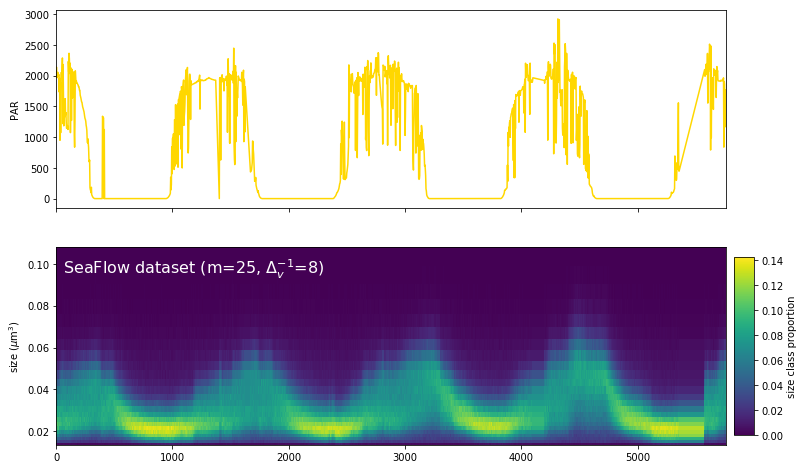

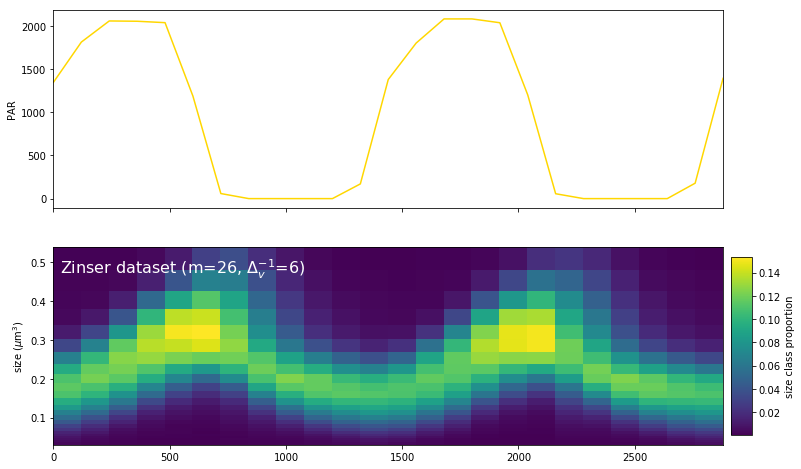

In [2]:
import matplotlib.pyplot as plt
import matplotlib as mpl
from mpl_toolkits.axes_grid1.inset_locator import inset_axes

def add_colorbar(ax, **cbarargs):
    axins_cbar = inset_axes(ax, width='3%', height='90%', loc=5, bbox_to_anchor=(0.05,0.0,1,1), bbox_transform=ax.transAxes)
    mpl.colorbar.ColorbarBase(axins_cbar, orientation='vertical', **cbarargs)

for i,k in enumerate(data_gridded):
    nrows = 2
    fig,axs = plt.subplots(nrows=nrows, sharex=True, figsize=(12,4*nrows))

    ax = axs[0]
    ax.plot(data_gridded[k]['time'], data_gridded[k]['PAR'], color='gold')
    ax.set(ylabel='PAR')

    v_min = data_gridded[k]['v_min']
    delta_v = 1.0/data_gridded[k]['delta_v_inv']
    v = v_min * 2**(np.arange(data_gridded[k]['m'])*delta_v) 
    
    ax = axs[1]
    pc = ax.pcolormesh(data_gridded[k]['time'],v,data_gridded[k]['w_obs'])
    ax.set(ylabel='size ($\mu$m$^3$)')
    ax.text(0.01, 0.95, desc[k], color='white', size=16, transform=ax.transAxes, ha='left', va='top')
    add_colorbar(ax, norm=pc.norm, cmap=pc.cmap, label='size class proportion')
axs[-1].set_xlabel=('time (minutes)')
None

### process data and plot it

In [3]:
# prepare data for Stan model

data = {}
mcmcs = {}
models = {}

In [4]:
for k in data_gridded:
    dt = 20 # in units of minutes
    
    data[k] = {'dt':dt}
    for v in ('m','v_min','delta_v_inv'):
        data[k][v] = data_gridded[k][v]

    if 'seaflow' in k:
        limit_days = 1
        
        # new: average SeaFlow data in hourly bins
        binsize = 60 # in minutes
        numbins = int(np.ceil(data_gridded[k]['time'][-1]/binsize))
        
        data[k]['obs'] = np.full((data[k]['m'],numbins), fill_value=np.nan)
        data[k]['t_obs'] = np.full(numbins, fill_value=np.nan)
        
        i = 0
        for ibin in range(numbins):
            binind = np.logical_and(data_gridded[k]['time'] >= ibin*binsize,
                                    data_gridded[k]['time'] < (ibin+1)*binsize)
            if np.any(binind):
                # TODO we may want to make this a sum when dealing with counts
                data[k]['obs'][:,i] = np.mean(data_gridded[k]['w_obs'][:,binind], axis=1)
                data[k]['t_obs'][i] = (ibin+0.5) * binsize
                i += 1
        
        data[k]['obs'] = data[k]['obs'][:,:i]
        data[k]['t_obs'] = data[k]['t_obs'][:i]
        
        # median filter PAR
        # see: medianfilter_par.ipynb
        n = len(data_gridded[k]['PAR'])
        wsh = 30 # half of median filter window size; window size is 2*wsh+1
        par = np.array([np.median(data_gridded[k]['PAR'][max(0,i-wsh):min(n,i+wsh+1)]) for i in range(n)])
    else:
        limit_days = 2
        
        data[k]['obs'] = data_gridded[k]['w_obs']
        data[k]['t_obs'] = data_gridded[k]['time']
        par = data_gridded[k]['PAR']
        
    if limit_days > 0:
        limit_minutes = limit_days*1440
        
        ind_obs = data[k]['t_obs'] < limit_minutes
        data[k]['t_obs'] = data[k]['t_obs'][ind_obs]
        data[k]['obs'] = data[k]['obs'][:,ind_obs]
        
        data[k]['nt'] = int(limit_minutes//data[k]['dt'])

    data[k]['nt_obs'] = data[k]['t_obs'].size
    
    # load cross-validation testing indices and add them to data
    data[k]['i_test'] = np.loadtxt(itestfiles[k]).astype(int)
    # remove last index, so that dimensions agree
    data[k]['i_test'] = data[k]['i_test'][:-1]
    
    # add light data
    t = np.arange(data[k]['nt'])*data[k]['dt']
    data[k]['E'] = np.interp(t, xp=data_gridded[k]['time'], fp=par)
    
    # for now, add pseudo-count data
    data[k]['obs_count'] = (1000*data[k]['obs']).astype(int)
    
    # consistency check
    if len(data[k]['i_test']) != data[k]['nt_obs']:
        raise ValueError('Invalid number of testing indices for "{}" (expected {}, got {}).'.format(k,data[k]['nt_obs'],len(data[k]['i_test'])))

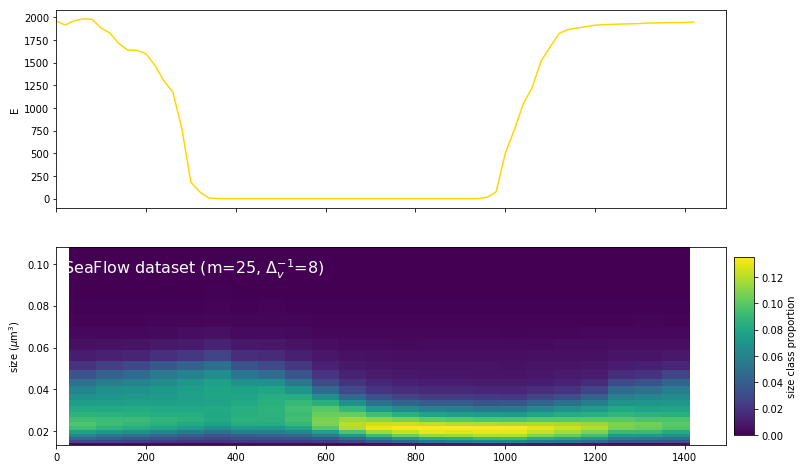

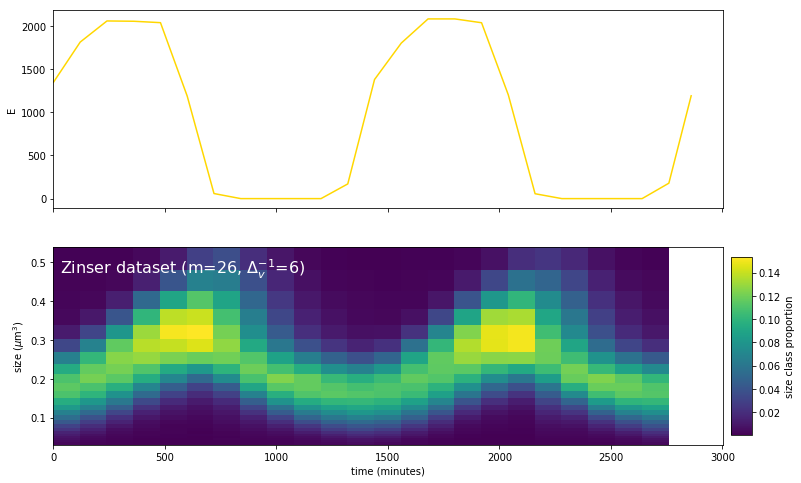

In [5]:
for i,k in enumerate(data):
    nrows = 2
    fig,axs = plt.subplots(nrows=nrows, sharex=True, figsize=(12,4*nrows))

    ax = axs[0]
    t = np.arange(data[k]['nt'])*data[k]['dt']
    ax.plot(t, data[k]['E'], color='gold')
    ax.set(ylabel='E')

    v_min = data[k]['v_min']
    delta_v = 1.0/data[k]['delta_v_inv']
    v = v_min * 2**(np.arange(data[k]['m'])*delta_v) 
    
    ax = axs[1]
    pc = ax.pcolormesh(data[k]['t_obs'],v,data[k]['obs'])
    ax.set(ylabel='size ($\mu$m$^3$)')
    ax.text(0.01, 0.95, desc[k], color='white', size=16, transform=ax.transAxes, ha='left', va='top')
    add_colorbar(ax, norm=pc.norm, cmap=pc.cmap, label='size class proportion')
    ax.set_xlim(left=0.0)
axs[-1].set_xlabel('time (minutes)')

None

# The model

modified from *Sosik et al. (2003), Growth rates of coastal phytoplankton from time-series measurements with a submersible flow cytometer, Limnol. Oceanogr.*

In [6]:
import pystan
refit_all = False
refit_required = {}

modelfiles = {
    'monodelta_respv2_mn':'stancode/matrixmodel_multinom_estinilnorm_monodelta_respv2_normparam_trackgrowth_xval.stan',
    'monodelta_respv2_lightsig_mn':'stancode/matrixmodel_multinom_estinilnorm_monodelta-lightsig_respv2_normparam_trackgrowth_xval.stan',
    'monodelta_respi_mn':'stancode/matrixmodel_multinom_estinilnorm_monodelta_respi_gammai_normparam_trackgrowth_xval.stan',
    'monodelta_respi_lightsig_mn':'stancode/matrixmodel_multinom_estinilnorm_monodelta-lightsig_respi_gammai_normparam_trackgrowth_xval.stan',
    'monodelta_respiv2_mn':'stancode/matrixmodel_multinom_estinilnorm_monodelta_respiv2_normparam_trackgrowth_xval.stan',
    'monodelta_respiv3_mn':'stancode/matrixmodel_multinom_estinilnorm_monodelta_respiv3_normparam_trackgrowth_xval.stan',
    'monodelta_respiv3_lightsig_mn':'stancode/matrixmodel_multinom_estinilnorm_monodelta-lightsig_respiv3_normparam_trackgrowth_xval.stan',
    'monodelta_respiv4_mn':'stancode/matrixmodel_multinom_estinilnorm_monodelta_respiv4_normparam_trackgrowth_xval.stan',
}
desc_model = {
    'monodelta_respv2_mn':'resp v2, monotone deltas (exp AR1), multinomial',
    'monodelta_respv2_lightsig_mn':'resp v2, light-dep division, monotone deltas (exp AR1), multinomial',
    'monodelta_respi_mn':'size-dep resp (old), monotone deltas (exp AR1), multinomial',
    'monodelta_respi_lightsig_mn':'size-dep resp (old), light-dep division, monotone deltas (exp AR1), multinomial',
    'monodelta_respiv2_mn':'size-dep resp v2, monotone deltas (exp AR1), multinomial',
    'monodelta_respiv3_mn':'size-dep resp v3 (exp), monotone deltas (exp AR1), multinomial',
    'monodelta_respiv3_lightsig_mn':'size-dep resp v3 (exp), light-dep division, monotone deltas (exp AR1), multinomial',
    'monodelta_respiv4_mn':'size-dep resp v4 (old with exp), monotone deltas (exp AR1), multinomial',
}

for name in modelfiles:
    with open(modelfiles[name]) as f: 
        stan_code = f.read()
    refit_required[name] = True
    if name in models and models[name].model_code == stan_code:
        print('{}: unchanged code, not recompiling'.format(name))
        refit_required[name] = False
    else:
        if name in models:
            print('{}: code change detected, recompiling'.format(name))
        else:
            print('{}: compiling'.format(name))
        models[name] = pystan.StanModel(file=modelfiles[name], model_name=name, obfuscate_model_name=False)

INFO:pystan:COMPILING THE C++ CODE FOR MODEL monodelta_respv2_mn NOW.


monodelta_respv2_mn: compiling


INFO:pystan:COMPILING THE C++ CODE FOR MODEL monodelta_respv2_lightsig_mn NOW.


monodelta_respv2_lightsig_mn: compiling


INFO:pystan:COMPILING THE C++ CODE FOR MODEL monodelta_respi_mn NOW.


monodelta_respi_mn: compiling


INFO:pystan:COMPILING THE C++ CODE FOR MODEL monodelta_respi_lightsig_mn NOW.


monodelta_respi_lightsig_mn: compiling


INFO:pystan:COMPILING THE C++ CODE FOR MODEL monodelta_respiv2_mn NOW.


monodelta_respiv2_mn: compiling


INFO:pystan:COMPILING THE C++ CODE FOR MODEL monodelta_respiv3_mn NOW.


monodelta_respiv3_mn: compiling


INFO:pystan:COMPILING THE C++ CODE FOR MODEL monodelta_respiv3_lightsig_mn NOW.


monodelta_respiv3_lightsig_mn: compiling


INFO:pystan:COMPILING THE C++ CODE FOR MODEL monodelta_respiv4_mn NOW.


monodelta_respiv4_mn: compiling


In [7]:
def get_max_rhat(fit):
    s = fit.summary()
    irhat = s['summary_colnames'].index("Rhat")
    return np.nanmax(s['summary'][:,irhat])

try_again = False

# run a bunch of experiments -- this may take a while
for name in models:
    for k in data:
        if name in mcmcs:
            if k in mcmcs[name] and not refit_all and not refit_required[name]:
                print('{} ({})'.format(name, desc_model[name])) 
                print('\n'.join(x for x in mcmcs[name][k].__str__().split('\n') if 'mod_obspos' not in x and 'theta' not in x and 'w_ini' not in x and 'incr' not in x))
                rhat_max = get_max_rhat(mcmcs[name][k])
                if try_again and rhat_max >= 1.1:
                    print('{}: found Rhat={:.3f}, trying again'.format(name,rhat_max))
                else:
                    continue
        else:
            mcmcs[name] = {}
        for itry in range(3):
            mcmcs[name][k] = models[name].sampling(data=data[k], iter=2000)
            # get max Rhat
            rhat_max = get_max_rhat(mcmcs[name][k])
            if rhat_max < 1.1:
                break
            print('{}: in try {}/3 found Rhat={:.3f}, trying again'.format(name,itry+1,rhat_max))
        print('{} ({})'.format(name, desc_model[name])) 
        print('\n'.join(x for x in mcmcs[name][k].__str__().split('\n') if 'mod_obspos' not in x and 'theta' not in x and 'w_ini' not in x and 'incr' not in x))

monodelta_respv2_mn (resp v2, monotone deltas (exp AR1), multinomial)
Inference for Stan model: monodelta_respv2_mn.
4 chains, each with iter=2000; warmup=1000; thin=1; 
post-warmup draws per chain=1000, total post-warmup draws=4000.

                      mean se_mean      sd    2.5%     25%     50%     75%   97.5%  n_eff   Rhat
delta_lambda          0.32  3.7e-3    0.09    0.17    0.25     0.3    0.37    0.54    661   1.01
gamma_max             1.25  1.7e-3    0.05    1.15    1.22    1.25    1.29    1.36    978    1.0
respiration           0.02  5.2e-4    0.02  1.2e-3    0.01    0.02    0.03    0.06    994    1.0
E_star               12.42    1.93   37.84    0.09    0.82    1.74    5.32    81.0    385   1.01
divrate               0.74  1.1e-3    0.03    0.68    0.72    0.74    0.76    0.79    765    1.0
delta_max[1]          0.16  1.0e-3    0.03     0.1    0.14    0.16    0.18    0.22    888    1.0
delta_max[2]          1.19  3.2e-3    0.09    1.02    1.13    1.18    1.24    1.36    

monodelta_respv2_lightsig_mn (resp v2, light-dep division, monotone deltas (exp AR1), multinomial)
Inference for Stan model: monodelta_respv2_lightsig_mn.
4 chains, each with iter=2000; warmup=1000; thin=1; 
post-warmup draws per chain=1000, total post-warmup draws=4000.

                      mean se_mean      sd    2.5%     25%     50%     75%   97.5%  n_eff   Rhat
delta_lambda          0.42  2.5e-3    0.13    0.21    0.33    0.41     0.5    0.73   2805    1.0
delta_lightthresh    94.87     1.1   69.09    3.49   38.94   83.13  138.04   257.4   3922    1.0
delta_lightsigma      0.19  3.0e-4    0.02    0.16    0.18    0.19    0.21    0.24   4533    1.0
gamma_max             0.73  9.6e-4    0.05    0.65     0.7    0.73    0.76    0.82   2248    1.0
respiration           0.11  5.7e-4    0.02    0.06    0.09    0.11    0.12    0.15   1821    1.0
E_star               18.37    0.65   36.55    0.23    2.36    6.35   18.59  113.08   3151    1.0
divrate               0.34  2.3e-4    0.01    0.

monodelta_respi_mn: in try 1/3 found Rhat=1.130, trying again


monodelta_respi_mn (size-dep resp (old), monotone deltas (exp AR1), multinomial)
Inference for Stan model: monodelta_respi_mn.
4 chains, each with iter=2000; warmup=1000; thin=1; 
post-warmup draws per chain=1000, total post-warmup draws=4000.

                      mean se_mean      sd    2.5%     25%     50%     75%   97.5%  n_eff   Rhat
delta_lambda          0.28  5.1e-3    0.08    0.16    0.22    0.27    0.32    0.45    230   1.01
gamma_max             3.25    0.02    0.35    2.62    3.03    3.22    3.46    4.03    225   1.04
xi                     0.3  3.5e-3    0.05     0.2    0.26    0.29    0.33    0.41    235   1.04
respiration            0.2  7.1e-3    0.07    0.08    0.15    0.19    0.24    0.37    101   1.05
xir                   0.17  7.2e-3    0.08    0.03    0.12    0.17    0.22    0.34    118   1.04
E_star               16.08    1.73   32.19     0.1    0.89    2.03   18.88   95.78    347   1.01
divrate               0.75  2.3e-3    0.04    0.68    0.73    0.75    0.78  

monodelta_respi_mn: in try 1/3 found Rhat=1081.547, trying again


monodelta_respi_mn: in try 2/3 found Rhat=1029.343, trying again


monodelta_respi_mn: in try 3/3 found Rhat=2717.230, trying again
monodelta_respi_mn (size-dep resp (old), monotone deltas (exp AR1), multinomial)
Inference for Stan model: monodelta_respi_mn.
4 chains, each with iter=2000; warmup=1000; thin=1; 
post-warmup draws per chain=1000, total post-warmup draws=4000.

                     mean se_mean     sd    2.5%     25%    50%    75%   97.5%  n_eff   Rhat
delta_lambda         2.46     1.1   1.66    0.69    0.92    1.4    3.9    5.66      2   2.72
gamma_max           14.18    1.09   1.87    11.6   11.61  14.74  15.16   17.94      3   1.73
xi                   -0.5    0.23   0.33   -0.91    -0.8  -0.51  -0.18  4.2e-4      2   7.93
respiration          1.69    0.95   1.35    0.29    0.34   1.43   3.03    3.32      2  11.85
xir                  0.26    0.22   0.32   -0.27   -0.03   0.39   0.54    0.54      2  11.09
E_star             1071.0   285.5 443.32  456.92  615.27 986.81 1378.7  1932.5      2   2.34
divrate              2.44    1.37   1.9

monodelta_respi_lightsig_mn (size-dep resp (old), light-dep division, monotone deltas (exp AR1), multinomial)
Inference for Stan model: monodelta_respi_lightsig_mn.
4 chains, each with iter=2000; warmup=1000; thin=1; 
post-warmup draws per chain=1000, total post-warmup draws=4000.

                      mean se_mean      sd    2.5%     25%     50%     75%   97.5%  n_eff   Rhat
delta_lambda          0.42  2.2e-3    0.13    0.21    0.33    0.41     0.5    0.72   3486    1.0
delta_lightthresh    109.7    1.23   73.77    5.88   50.63   99.36  156.82  280.21   3618    1.0
delta_lightsigma       0.2  2.9e-4    0.02    0.16    0.18     0.2    0.21    0.24   5034    1.0
gamma_max             1.57  3.2e-3    0.16    1.28    1.47    1.57    1.67     1.9   2464    1.0
xi                    0.13  5.9e-4    0.03    0.08    0.11    0.13    0.15     0.2   2870    1.0
respiration            0.4  2.1e-3    0.11    0.21    0.32    0.39    0.46    0.64   2629    1.0
xir                    0.2  1.4e-3    

monodelta_respi_lightsig_mn: in try 1/3 found Rhat=6290.941, trying again
monodelta_respi_lightsig_mn (size-dep resp (old), light-dep division, monotone deltas (exp AR1), multinomial)
Inference for Stan model: monodelta_respi_lightsig_mn.
4 chains, each with iter=2000; warmup=1000; thin=1; 
post-warmup draws per chain=1000, total post-warmup draws=4000.

                      mean se_mean      sd    2.5%     25%     50%     75%   97.5%  n_eff   Rhat
delta_lambda          3.83    0.01    0.87    2.36     3.2    3.75     4.4    5.71   6081    1.0
delta_lightthresh   772.05    1.38   86.92  593.53  714.78  773.45  831.07  942.27   3990    1.0
delta_lightsigma      0.28  2.5e-4    0.02    0.24    0.27    0.28    0.29    0.31   5057    1.0
gamma_max             9.37    0.01    0.55    8.39    8.99    9.34    9.72   10.55   2115    1.0
xi                   -0.77  1.0e-3    0.06   -0.89   -0.81   -0.76   -0.73   -0.65   3470    1.0
respiration            3.3  3.4e-3    0.19    2.93    3.17   

monodelta_respiv2_mn (size-dep resp v2, monotone deltas (exp AR1), multinomial)
Inference for Stan model: monodelta_respiv2_mn.
4 chains, each with iter=2000; warmup=1000; thin=1; 
post-warmup draws per chain=1000, total post-warmup draws=4000.

                      mean se_mean      sd    2.5%     25%     50%     75%   97.5%  n_eff   Rhat
delta_lambda          0.28  3.3e-3    0.07    0.17    0.23    0.27    0.33    0.46    475   1.02
gamma_max             3.49    0.03     0.4    2.72    3.22    3.47    3.77    4.25    211   1.02
xi                    0.35  4.2e-3    0.06    0.23    0.31    0.35    0.39    0.47    213   1.02
respiration           0.21  6.6e-3    0.08    0.06    0.16    0.21    0.27    0.38    153   1.04
E_star               16.15    2.73   32.01     0.1    0.96    2.05   21.65   88.32    138   1.03
divrate               0.78  2.1e-3    0.03    0.71    0.75    0.78     0.8    0.84    251   1.01
delta_max[1]          0.09  1.9e-3    0.03    0.04    0.07    0.08     0.1 

monodelta_respiv2_mn: in try 1/3 found Rhat=1420.223, trying again


monodelta_respiv2_mn: in try 2/3 found Rhat=4710.426, trying again


monodelta_respiv2_mn (size-dep resp v2, monotone deltas (exp AR1), multinomial)
Inference for Stan model: monodelta_respiv2_mn.
4 chains, each with iter=2000; warmup=1000; thin=1; 
post-warmup draws per chain=1000, total post-warmup draws=4000.

                      mean se_mean      sd    2.5%     25%     50%     75%   97.5%  n_eff   Rhat
delta_lambda           1.9  5.8e-3    0.42    1.18     1.6    1.87    2.17     2.8   5273    1.0
gamma_max             9.54    0.01    0.56     8.5    9.15    9.51    9.89    10.7   3018    1.0
xi                   -0.71  1.1e-3    0.06   -0.84   -0.76   -0.71   -0.67   -0.59   3208    1.0
respiration           3.07  2.6e-3    0.16    2.77    2.96    3.07    3.17    3.39   3444    1.0
E_star              739.54    1.76  107.73  552.55  664.29  728.34  803.02  982.82   3744    1.0
divrate               0.71  4.5e-4    0.03    0.65    0.68    0.71    0.73    0.77   4637    1.0
delta_max[1]          0.08  5.2e-4    0.03    0.02    0.06    0.08     0.1 

monodelta_respiv3_mn (size-dep resp v3 (exp), monotone deltas (exp AR1), multinomial)
Inference for Stan model: monodelta_respiv3_mn.
4 chains, each with iter=2000; warmup=1000; thin=1; 
post-warmup draws per chain=1000, total post-warmup draws=4000.

                      mean se_mean      sd    2.5%     25%     50%     75%   97.5%  n_eff   Rhat
delta_lambda          0.31  3.8e-3     0.1    0.16    0.25     0.3    0.37    0.53    661    1.0
gamma_max             1.25  1.5e-3    0.05    1.14    1.21    1.25    1.29    1.35   1371    1.0
xi                    0.04  3.1e-3     0.1   -0.15   -0.03    0.04    0.11    0.23   1044    1.0
respiration           0.02  5.5e-4    0.02  1.7e-3    0.01    0.02    0.04    0.06    875    1.0
E_star               12.23     1.3   32.82    0.09    0.84    1.74    5.57   84.15    638    1.0
divrate               0.74  1.1e-3    0.03    0.68    0.72    0.74    0.76    0.79    751    1.0
delta_max[1]          0.16  1.2e-3    0.03     0.1    0.13    0.16   

monodelta_respiv3_mn: in try 1/3 found Rhat=2785.601, trying again


monodelta_respiv3_mn: in try 2/3 found Rhat=5779.724, trying again


monodelta_respiv3_mn: in try 3/3 found Rhat=108746.738, trying again
monodelta_respiv3_mn (size-dep resp v3 (exp), monotone deltas (exp AR1), multinomial)
Inference for Stan model: monodelta_respiv3_mn.
4 chains, each with iter=2000; warmup=1000; thin=1; 
post-warmup draws per chain=1000, total post-warmup draws=4000.

                      mean se_mean     sd    2.5%     25%    50%     75%  97.5%  n_eff   Rhat
delta_lambda          2.48    1.23   1.76    0.98    0.98   1.72    4.56   5.43      2   6.51
gamma_max             8.66    3.93   5.56    3.02    3.19   8.16   14.28  15.57      2  76.89
xi                   -0.66    0.16   0.23   -0.98   -0.89  -0.54   -0.43  -0.37      2   5.03
respiration           0.69    0.32   0.45    0.08    0.24    0.7    1.12    1.2      2  14.99
E_star              1465.9  663.19 939.87  479.23  618.23 1372.2  2368.3 2887.5      2  15.82
divrate               2.35     1.2   1.69    0.65     0.7   2.14    4.05   4.54      2  77.56
delta_max[1]         

monodelta_respiv3_lightsig_mn (size-dep resp v3 (exp), light-dep division, monotone deltas (exp AR1), multinomial)
Inference for Stan model: monodelta_respiv3_lightsig_mn.
4 chains, each with iter=2000; warmup=1000; thin=1; 
post-warmup draws per chain=1000, total post-warmup draws=4000.

                      mean se_mean      sd    2.5%     25%     50%     75%   97.5%  n_eff   Rhat
delta_lambda          0.42  2.5e-3    0.13    0.21    0.33     0.4     0.5    0.73   2754    1.0
delta_lightthresh    94.21    1.01   64.42    4.48   43.31   84.99  132.84   245.8   4040    1.0
delta_lightsigma      0.19  3.0e-4    0.02    0.16    0.18    0.19    0.21    0.23   4616    1.0
gamma_max             0.73  9.5e-4    0.05    0.64     0.7    0.73    0.76    0.82   2330    1.0
xi                  2.3e-3  1.4e-3     0.1   -0.19   -0.06  1.6e-3    0.07     0.2   4801    1.0
respiration           0.11  5.4e-4    0.02    0.06    0.09    0.11    0.12    0.15   1996    1.0
E_star               19.63    0

monodelta_respiv4_mn (size-dep resp v4 (old with exp), monotone deltas (exp AR1), multinomial)
Inference for Stan model: monodelta_respiv4_mn.
4 chains, each with iter=2000; warmup=1000; thin=1; 
post-warmup draws per chain=1000, total post-warmup draws=4000.

                      mean se_mean      sd    2.5%     25%      50%     75%   97.5%  n_eff   Rhat
delta_lambda           0.3  4.1e-3    0.09    0.16    0.23     0.29    0.35     0.5    498   1.01
gamma_max             1.29  2.1e-3    0.06    1.18    1.25     1.29    1.33     1.4    692    1.0
xi                    0.03  3.9e-3     0.1   -0.17   -0.05     0.03     0.1    0.22    679   1.01
respiration           0.11  9.9e-4    0.02    0.06     0.1     0.11    0.12    0.15    480   1.01
xir                -4.1e-3  4.3e-3     0.1   -0.19   -0.07  -2.6e-3    0.06    0.18    524   1.01
E_star                8.51     1.0   23.02    0.11     0.8     1.62    3.54   66.23    530   1.01
divrate               0.68  1.5e-3    0.03    0.62   

monodelta_respiv4_mn: in try 1/3 found Rhat=1708.586, trying again


monodelta_respiv4_mn: in try 2/3 found Rhat=965.960, trying again


monodelta_respiv4_mn: in try 3/3 found Rhat=1.195, trying again
monodelta_respiv4_mn (size-dep resp v4 (old with exp), monotone deltas (exp AR1), multinomial)
Inference for Stan model: monodelta_respiv4_mn.
4 chains, each with iter=2000; warmup=1000; thin=1; 
post-warmup draws per chain=1000, total post-warmup draws=4000.

                      mean se_mean     sd    2.5%     25%     50%     75%  97.5%  n_eff   Rhat
delta_lambda          1.87    0.04   0.49    1.02    1.52    1.82    2.18   2.95    174   1.02
gamma_max             4.54    0.54   2.57    3.76    3.95    4.08    4.25  12.61     23   1.14
xi                   -0.93    0.05   0.23    -1.0   -0.99   -0.98   -0.96   0.31     21   1.15
respiration           1.28    0.03   0.17    0.31    1.27    1.31    1.34    1.4     25   1.12
xir                    0.4    0.02   0.14   -0.15    0.35    0.41    0.48   0.61     33   1.09
E_star              1041.5   84.16 385.17  724.62  868.18  961.71  1085.2 3051.2     21   1.14
divrate   

## Plot the results

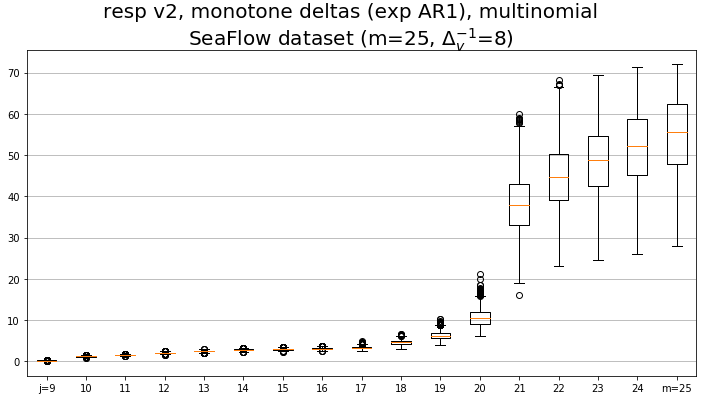

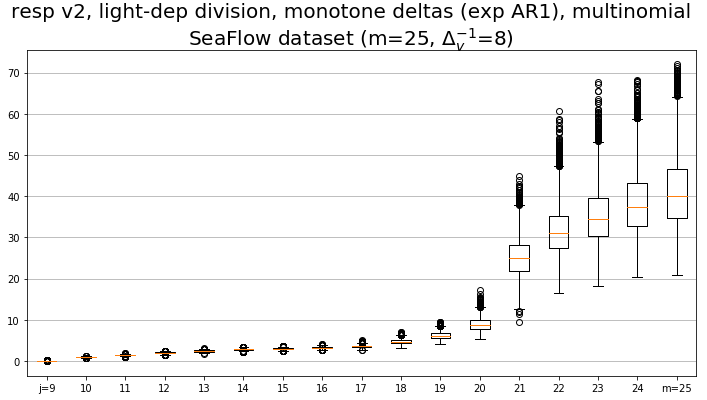

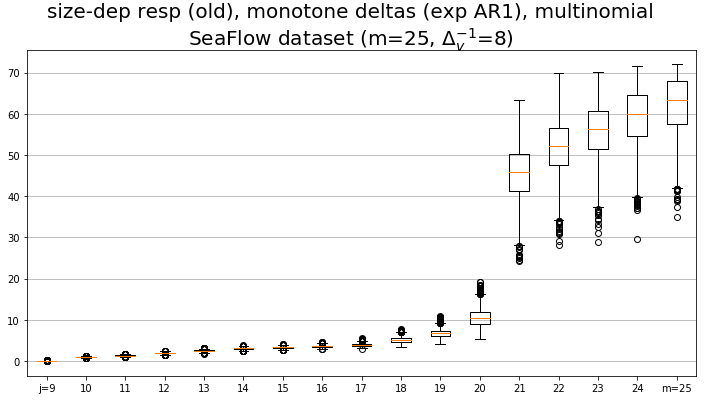

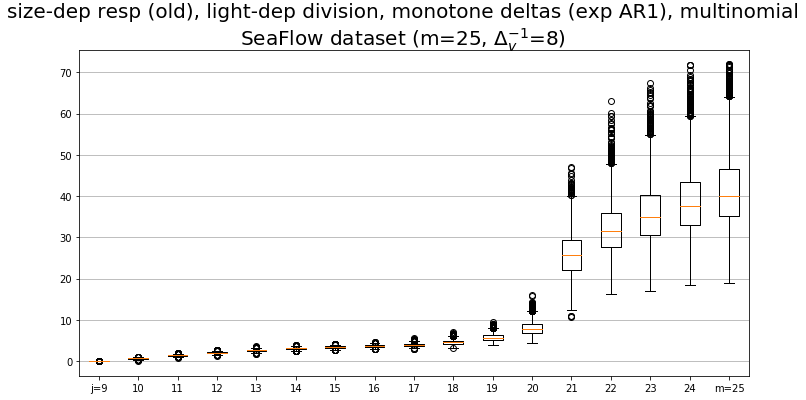

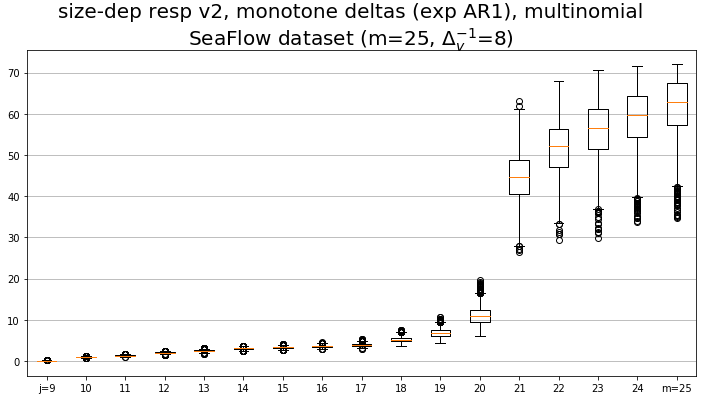

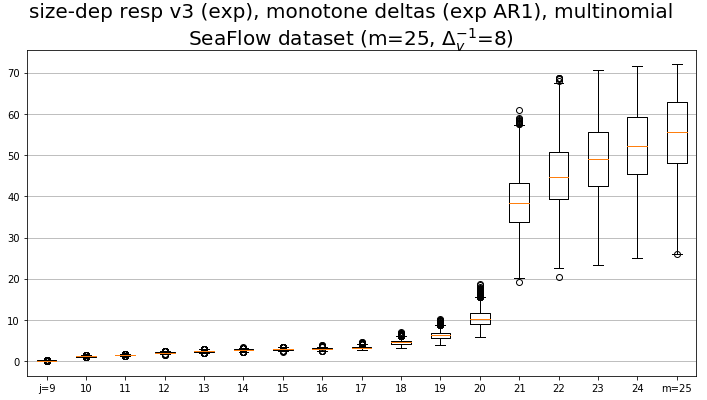

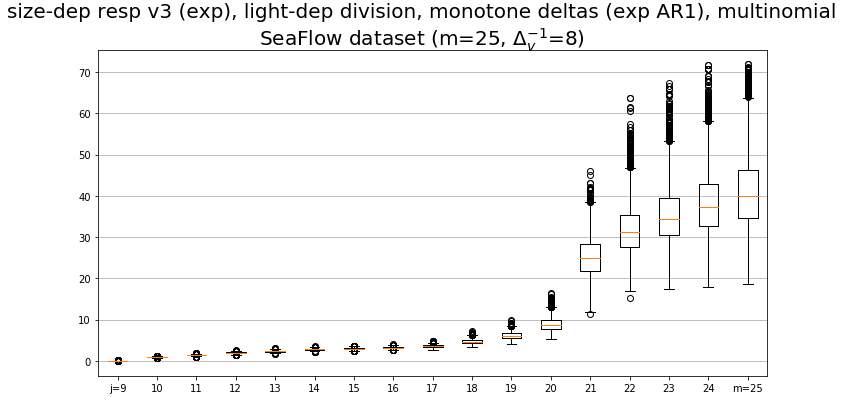

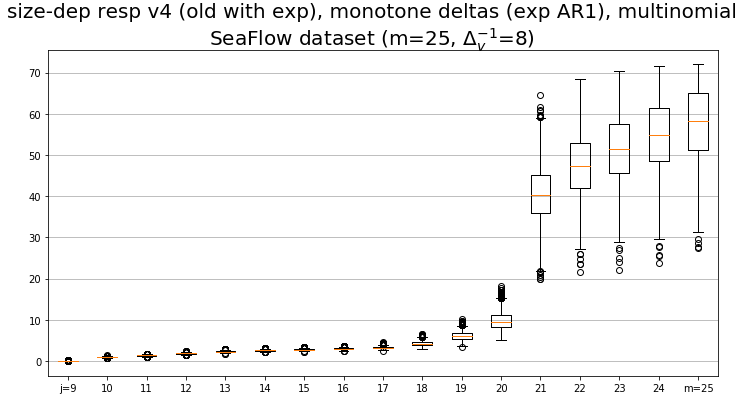

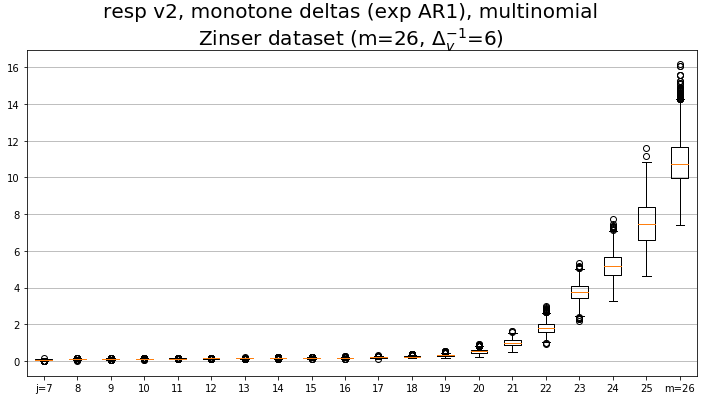

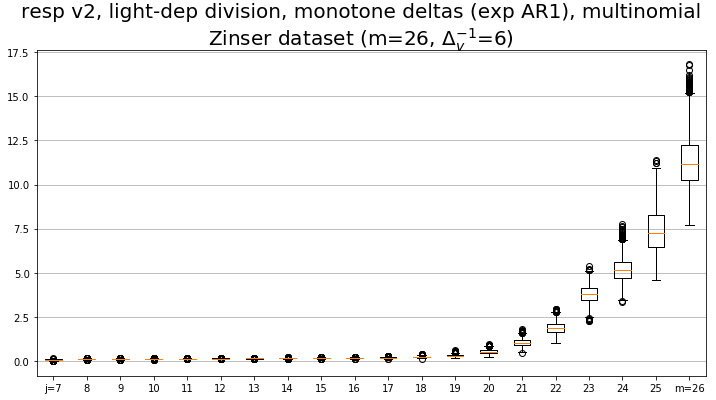

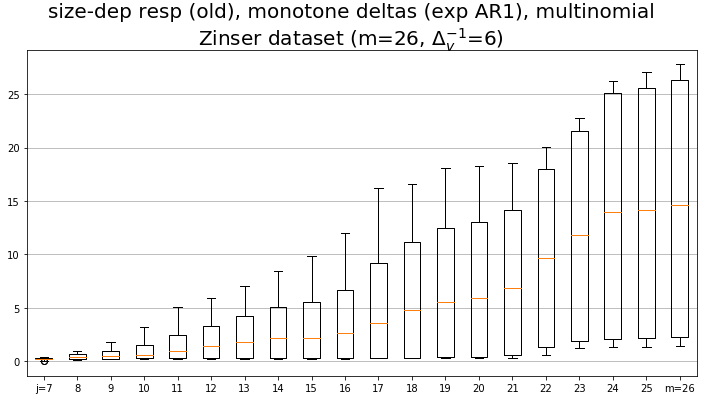

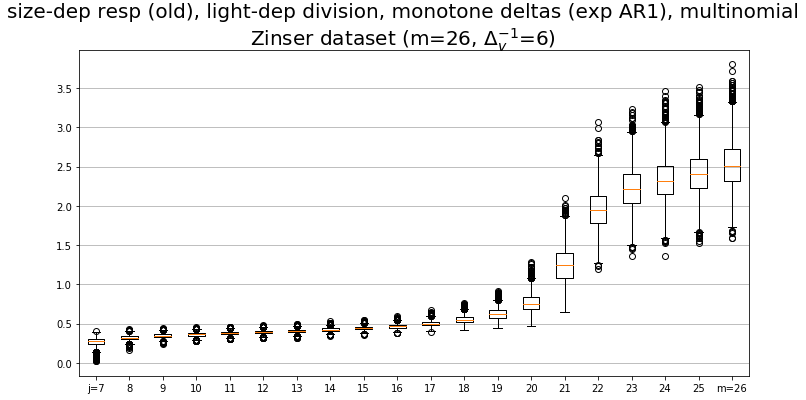

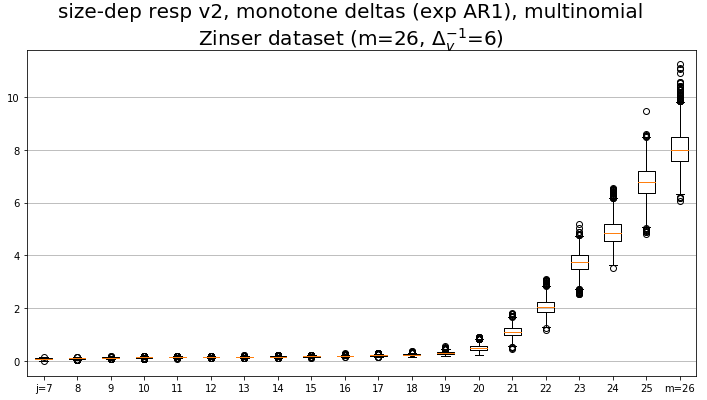

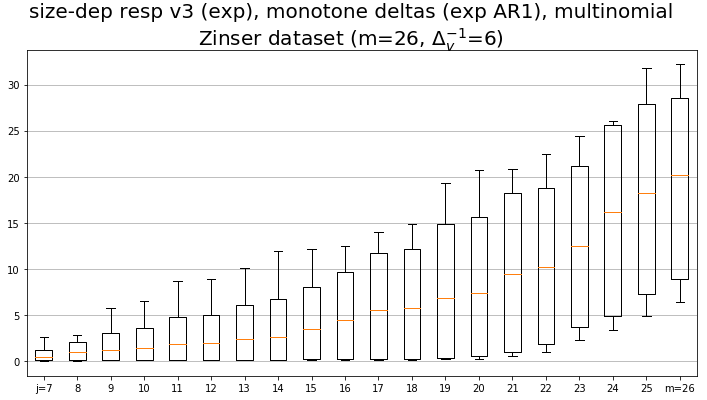

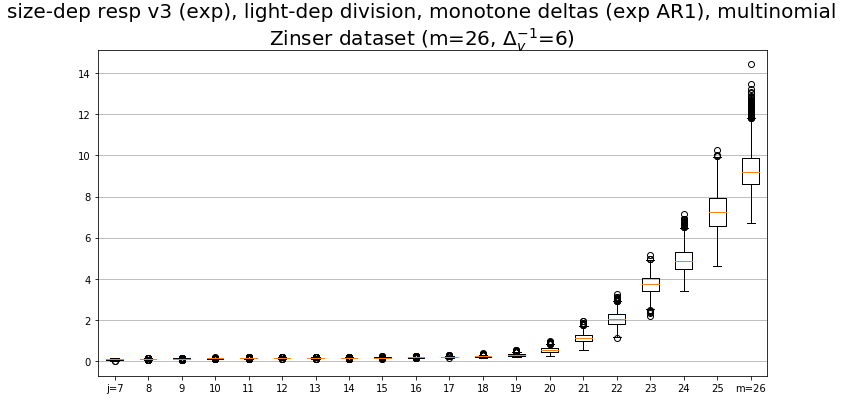

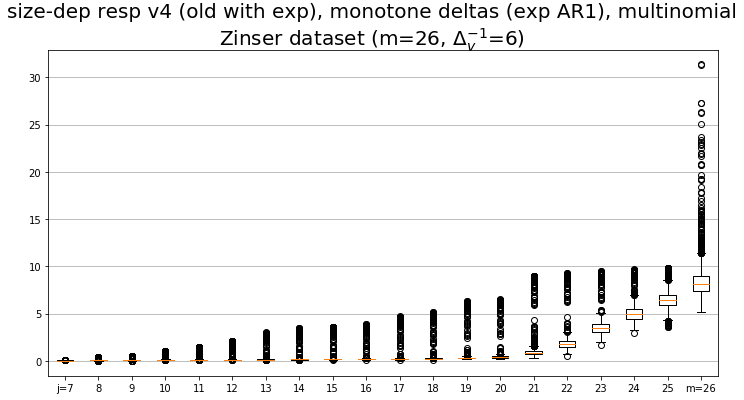

In [8]:
for k in data:
    for name,mcmc in mcmcs.items():
        j = data_gridded[k]['delta_v_inv'] + 1
        m = data_gridded[k]['m']

        fig, ax = plt.subplots(figsize=(12,6))
        fig.suptitle(desc_model[name] + '\n' + desc[k], size=20)
        ax.boxplot(mcmc[k]['delta_max'])
        xlabels = [str(x) for x in range(j,m+1)]
        xlabels[0] = 'j='+xlabels[0]
        xlabels[-1] = 'm='+xlabels[-1]
        ax.set_xticklabels(xlabels)
        ax.grid(axis='y')
        None

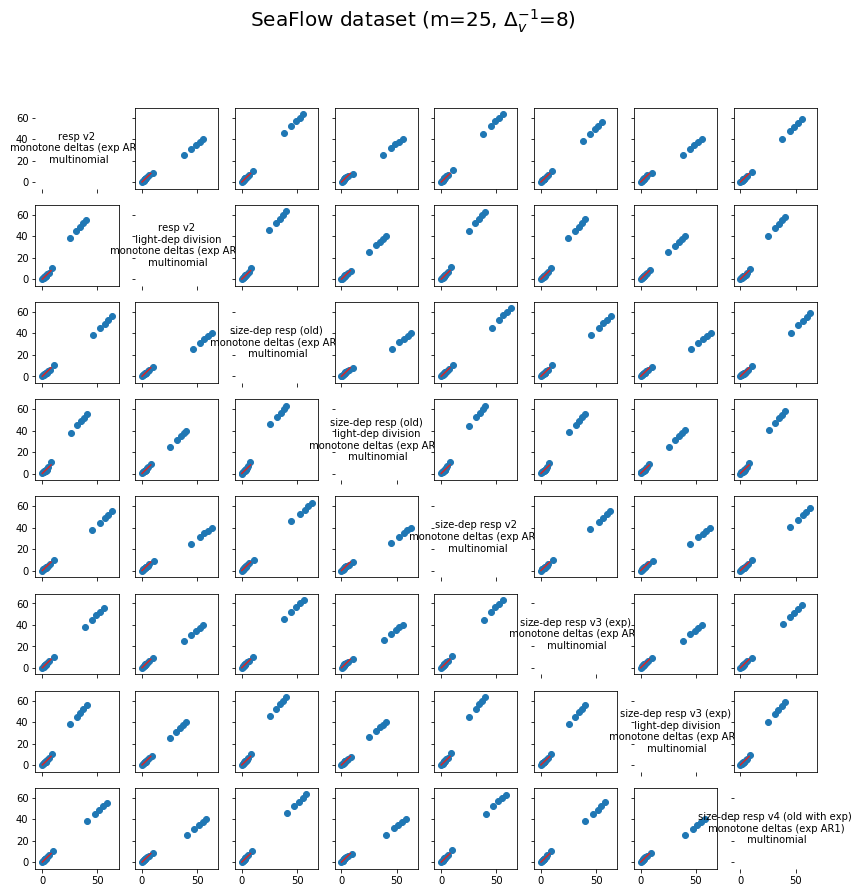

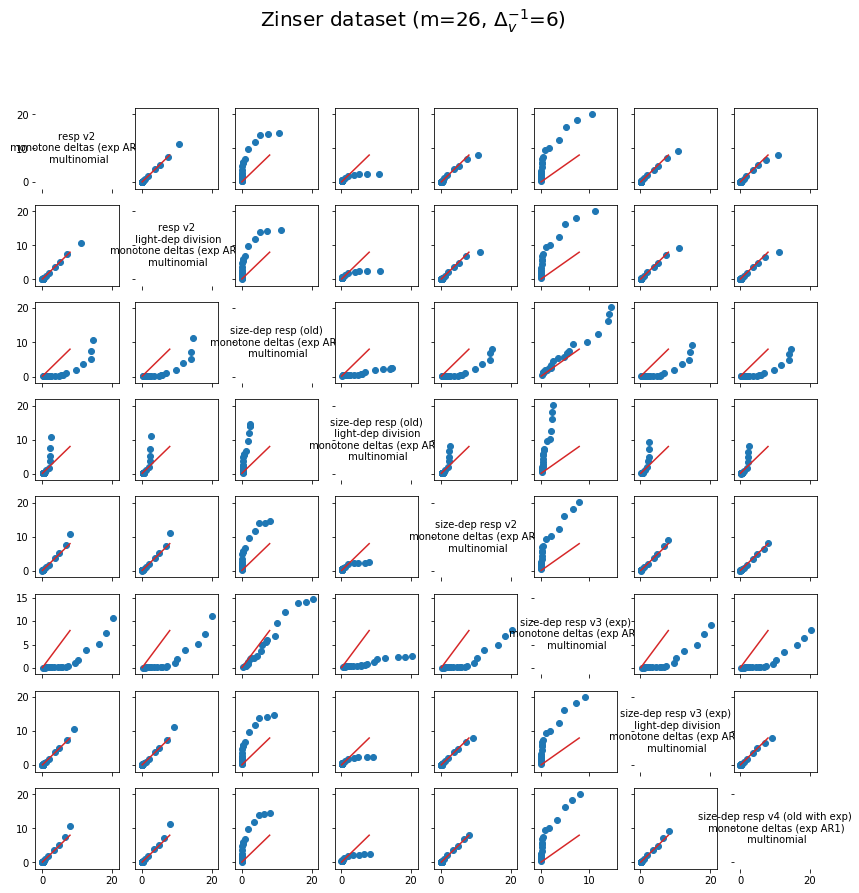

In [9]:
# create a 
for k in data:
    n = len(mcmcs)
    if n > 1:
        tmpdata = {}
        for name in mcmcs:
            tmpdata[name] = np.median(mcmcs[name][k]['delta_max'], axis=0)

        fig, axs = plt.subplots(nrows=n, ncols=n, figsize=(14,14), sharex='col', sharey='row')
        fig.suptitle(desc[k], size=20)
        for irow,colname in enumerate(mcmcs):
            for icol,rowname in enumerate(mcmcs):
                ax = axs[irow,icol]
                if irow == icol:
                    for loc in ax.spines:
                        ax.spines[loc].set_visible(False)
                    #ax.set_visible(False)
                    #ax.set(xticks=[], yticks=[])
                    ax.text(0.5, 0.5, desc_model[colname].replace(',','\n'), transform=ax.transAxes, va='center', ha='center')
                    continue
                ax.scatter(tmpdata[colname],tmpdata[rowname])
                ax.plot([0.1, 8.0], [0.1, 8.0], color='tab:red')

/usr/lib/python3/dist-packages/matplotlib/pyplot.py:528: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)


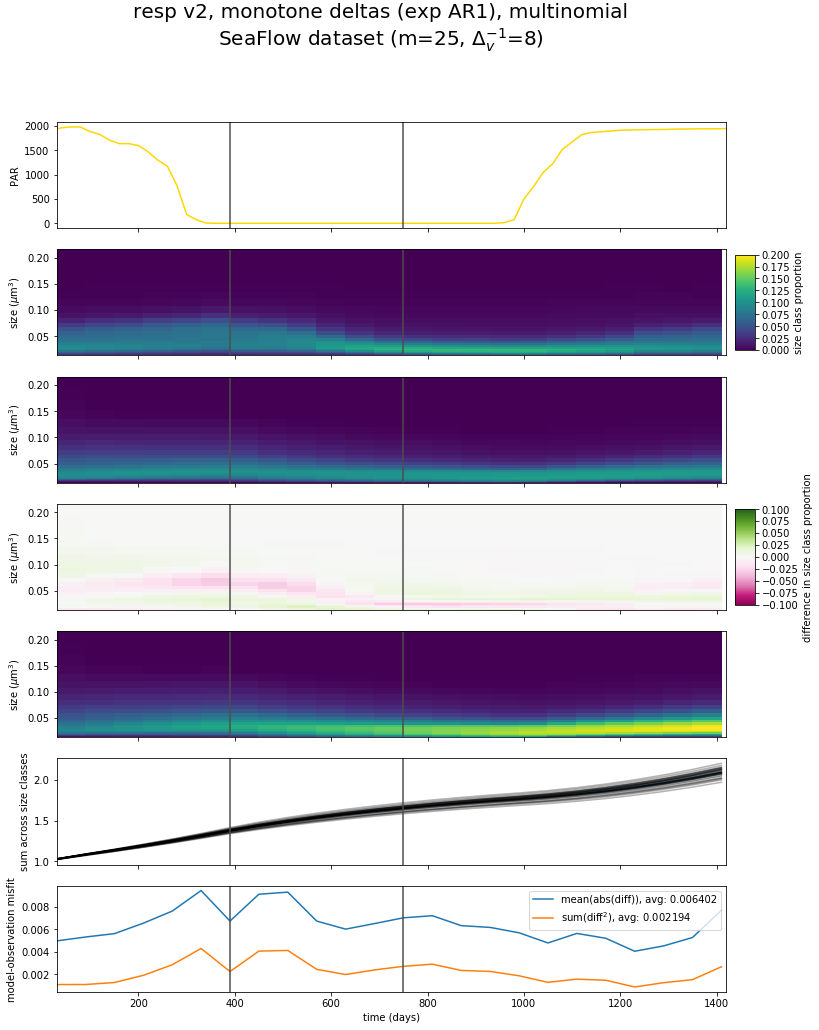

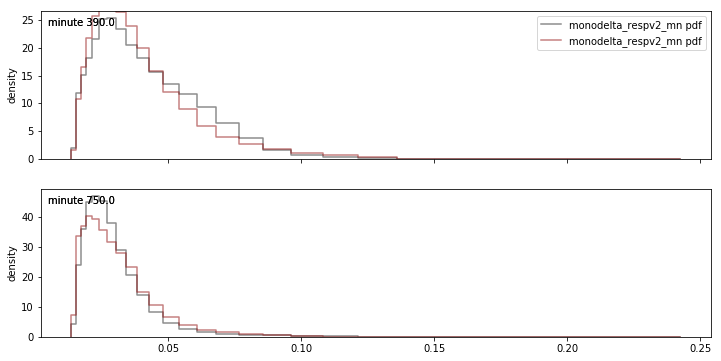

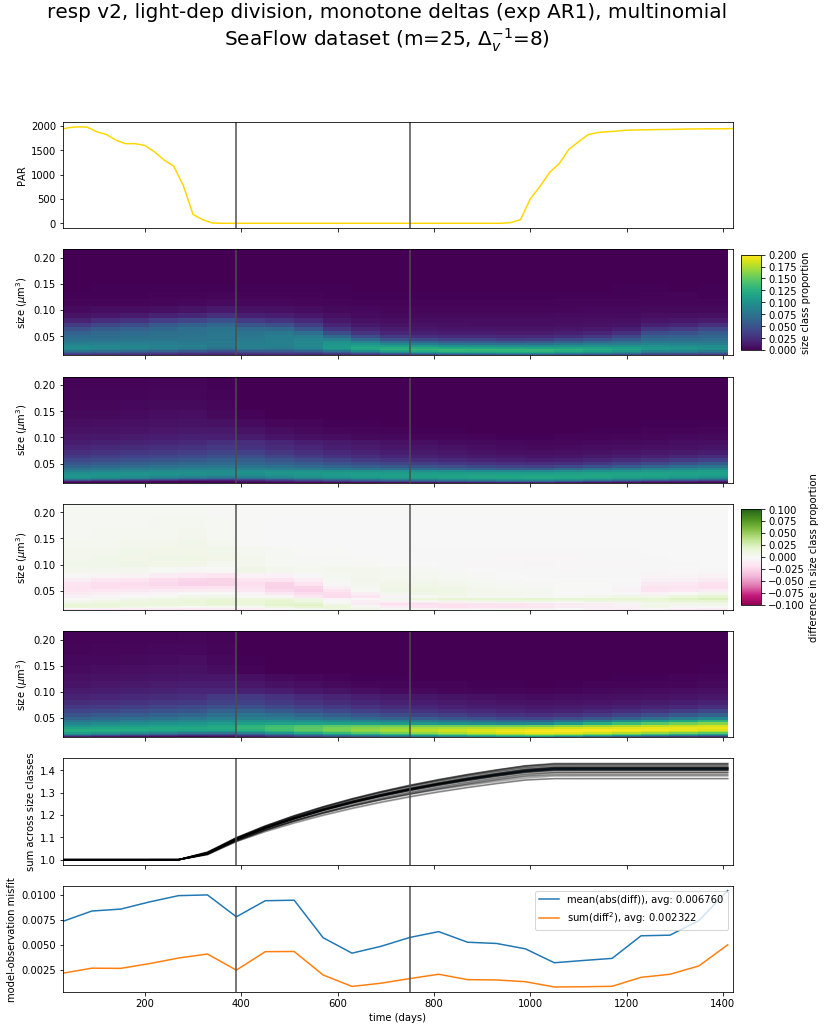

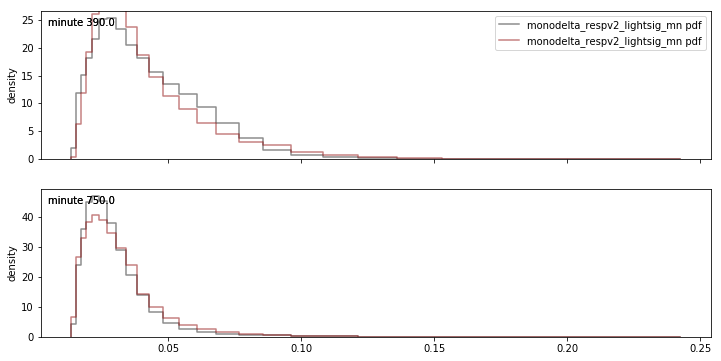

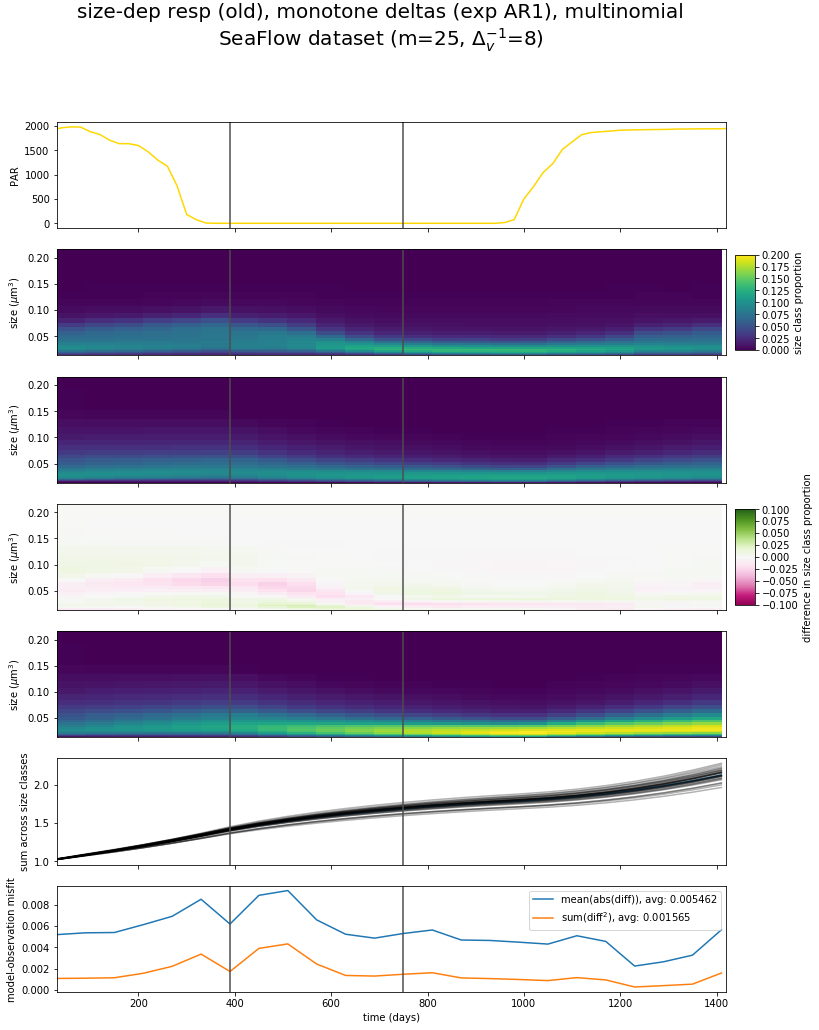

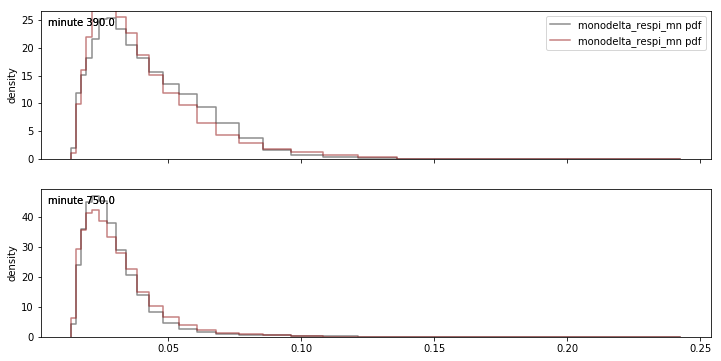

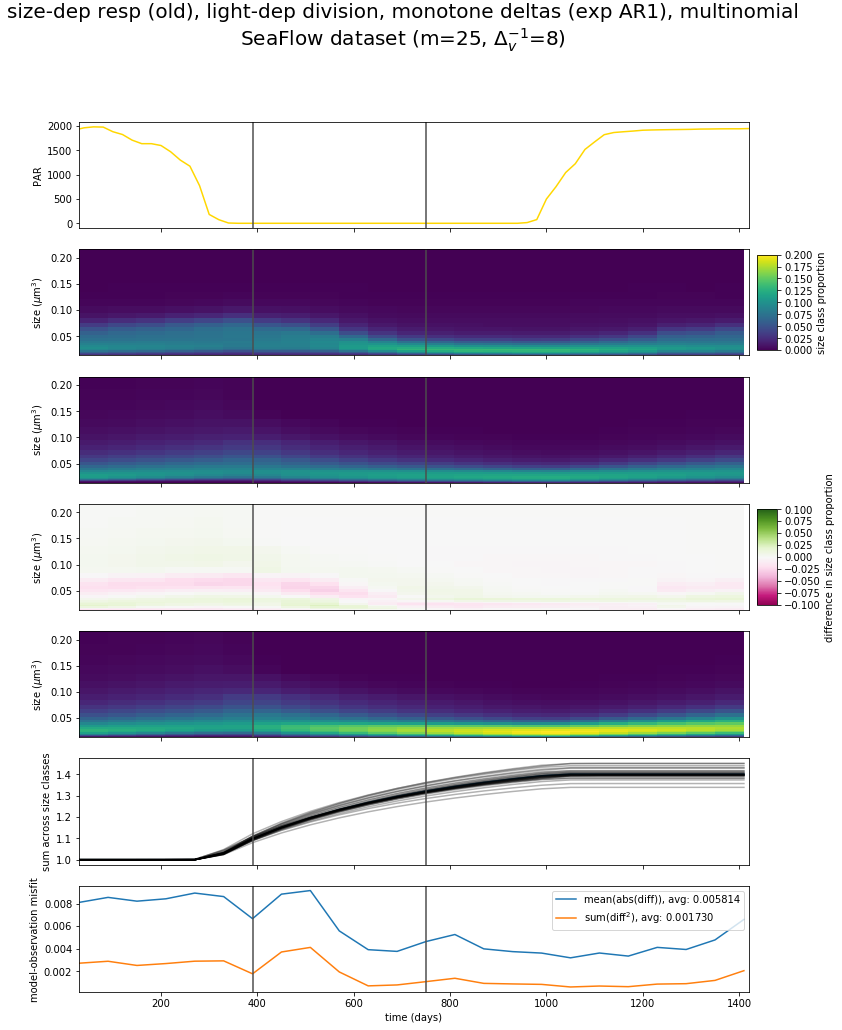

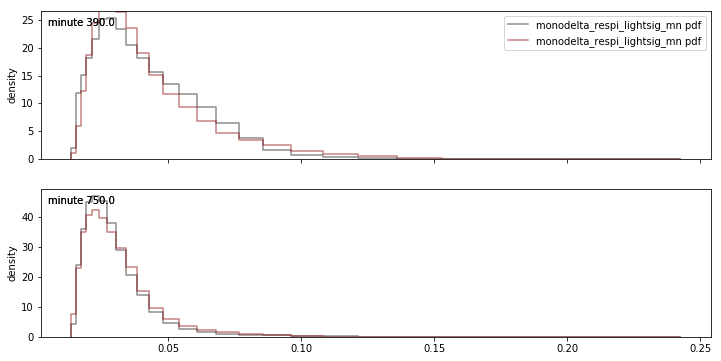

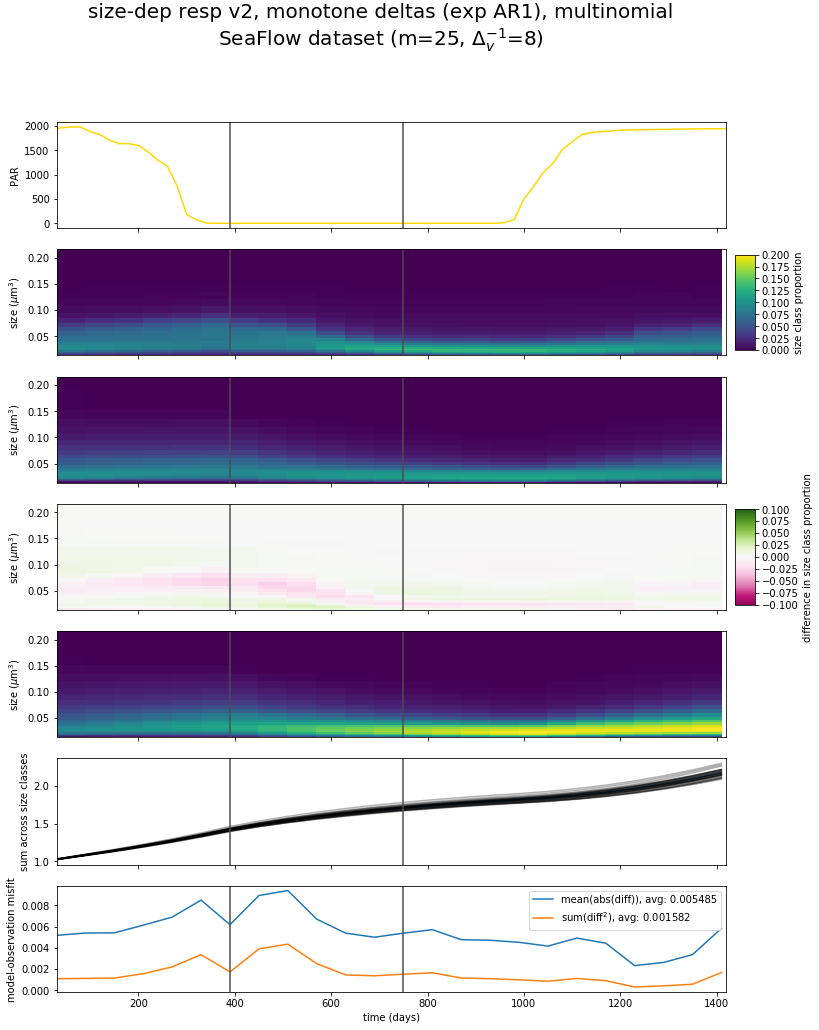

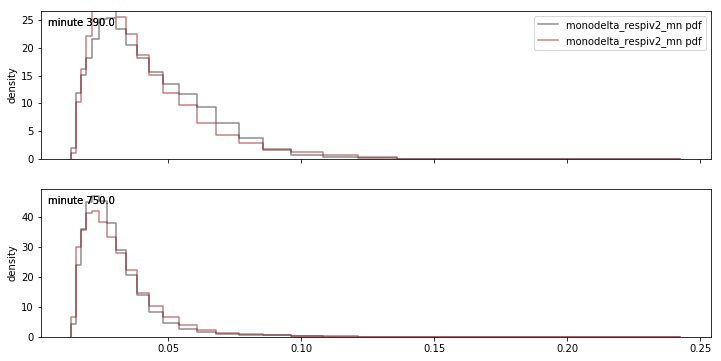

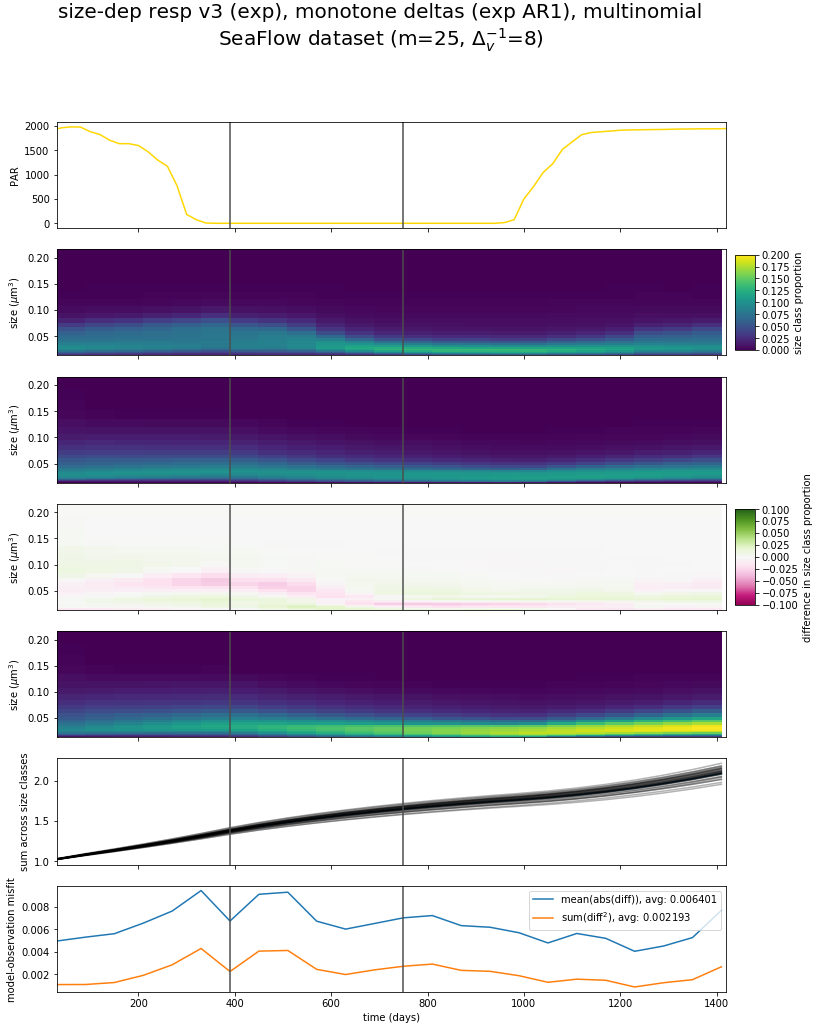

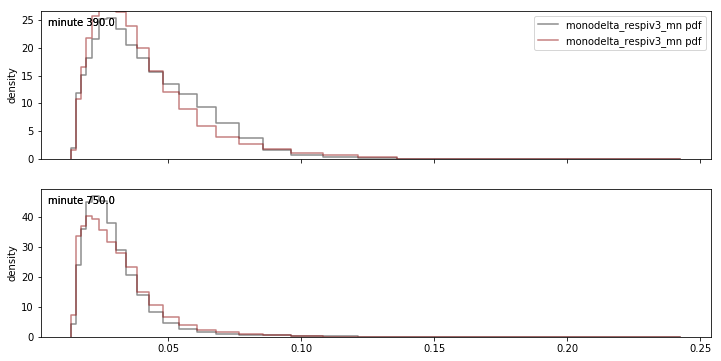

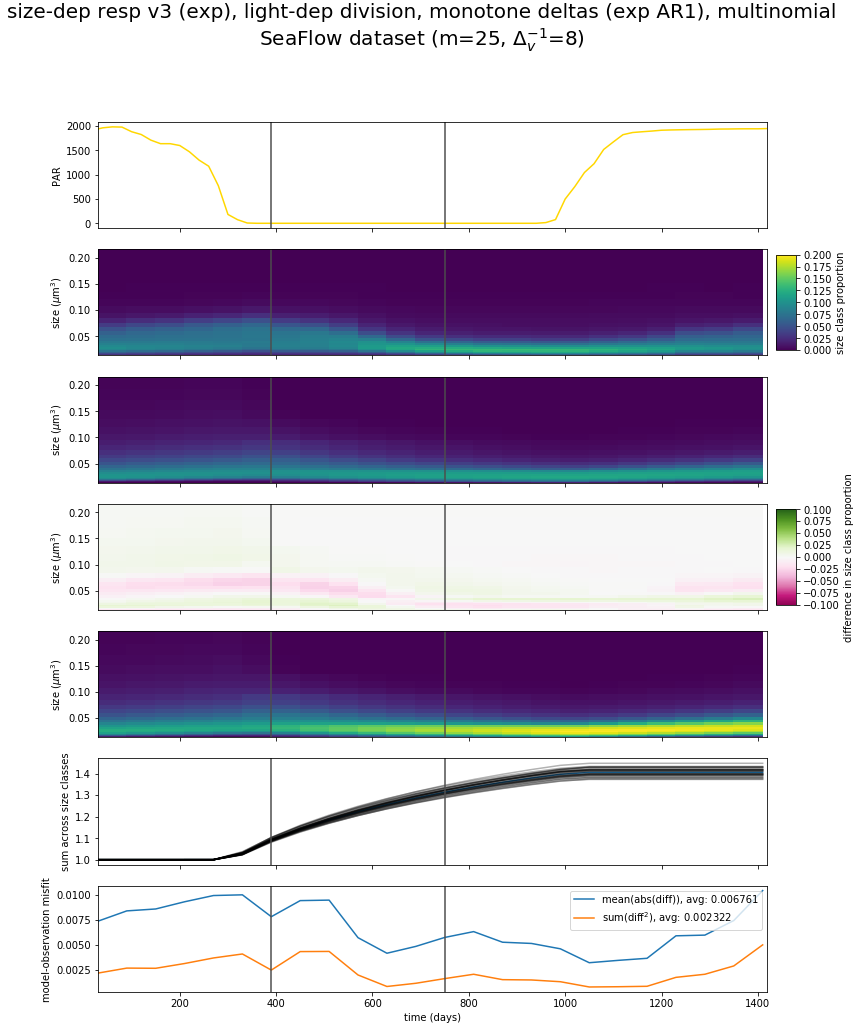

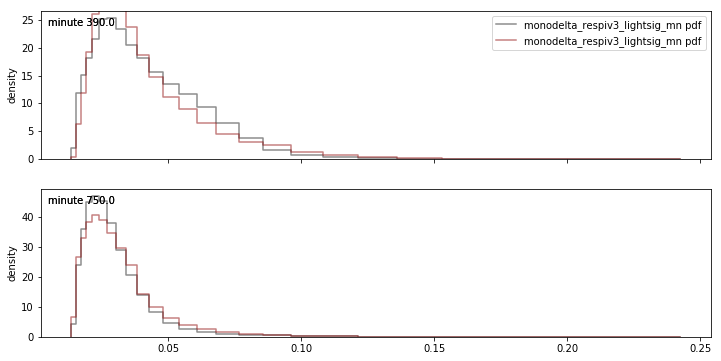

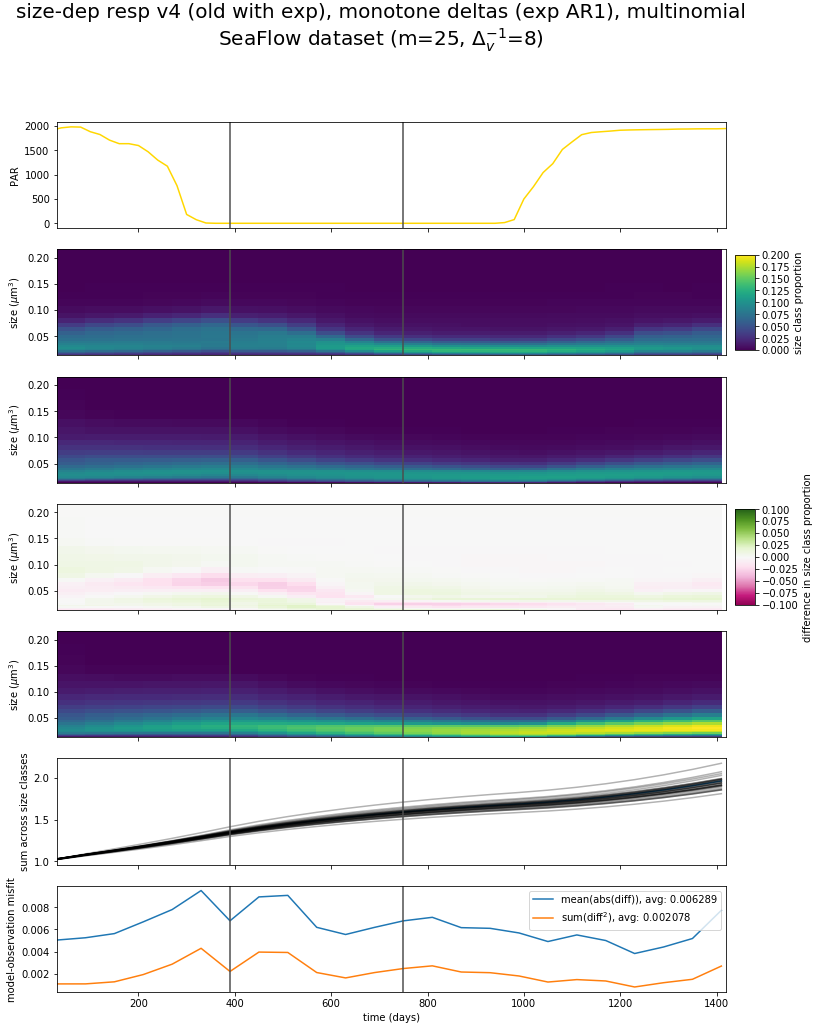

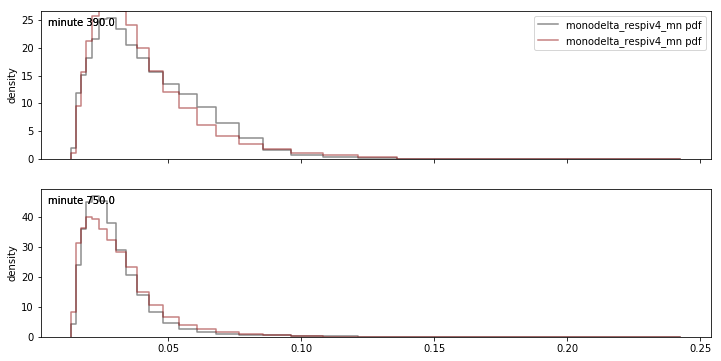

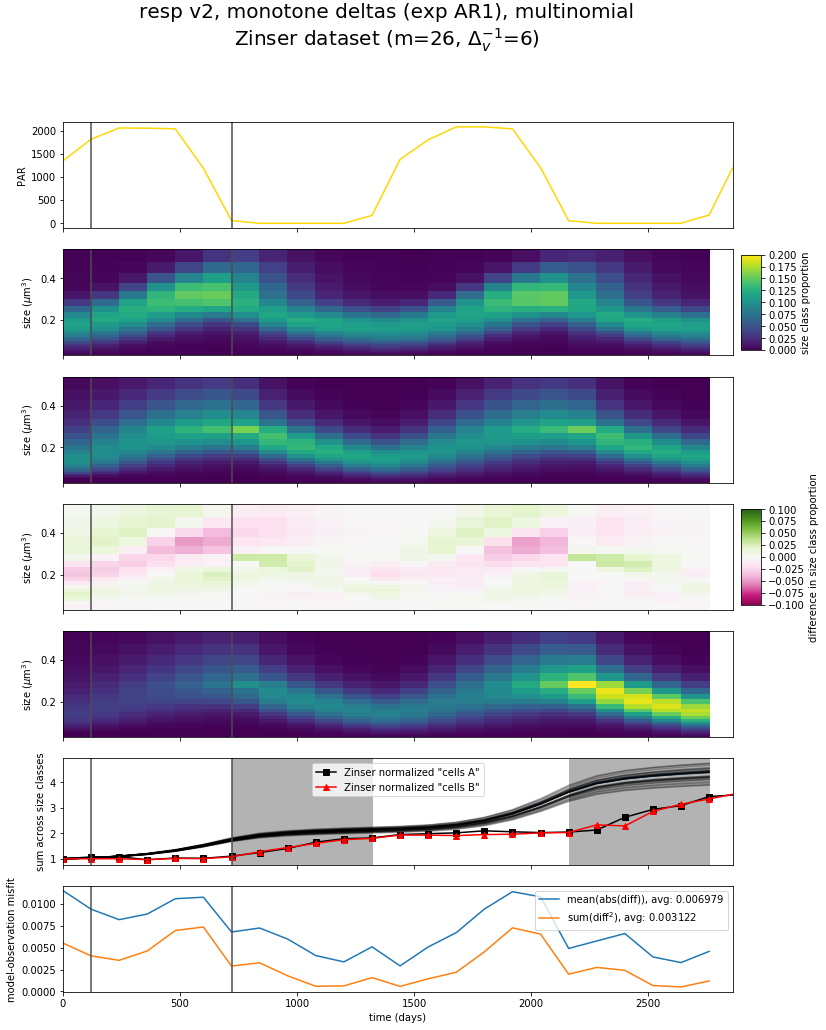

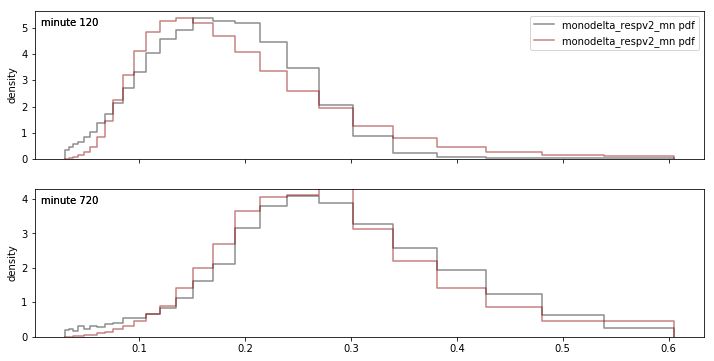

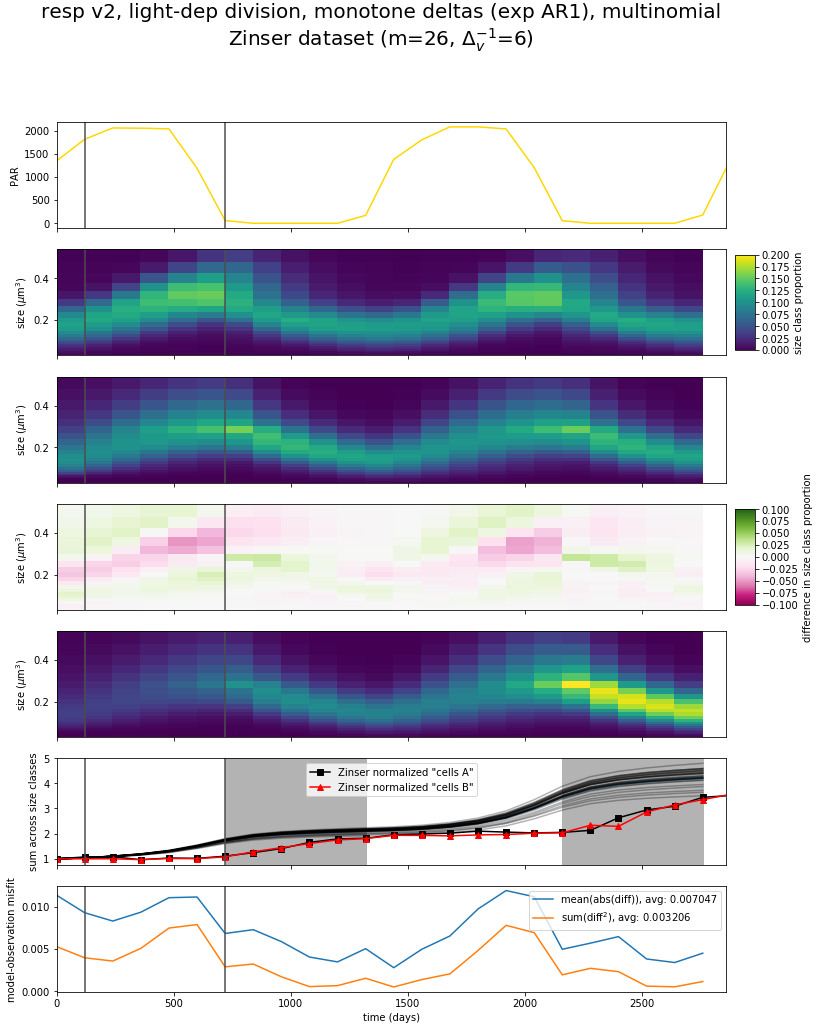

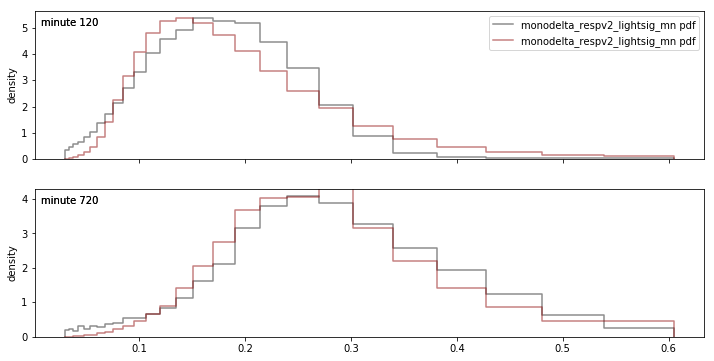

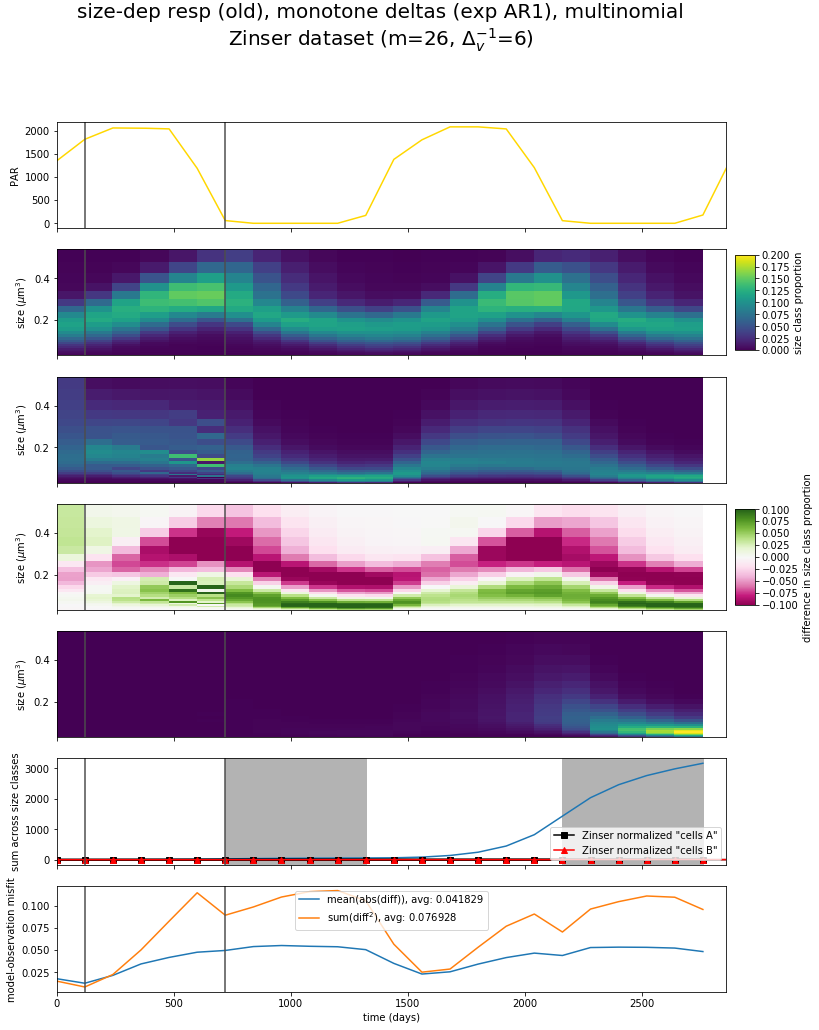

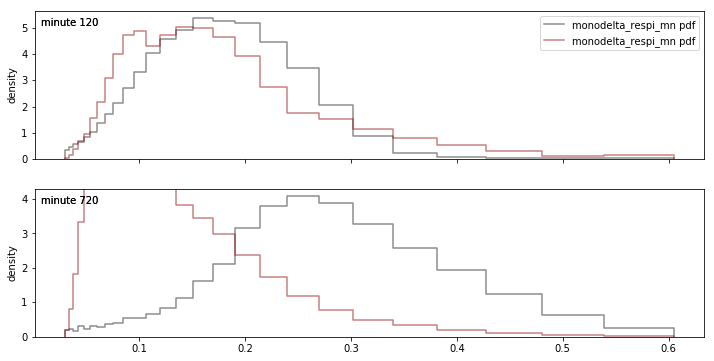

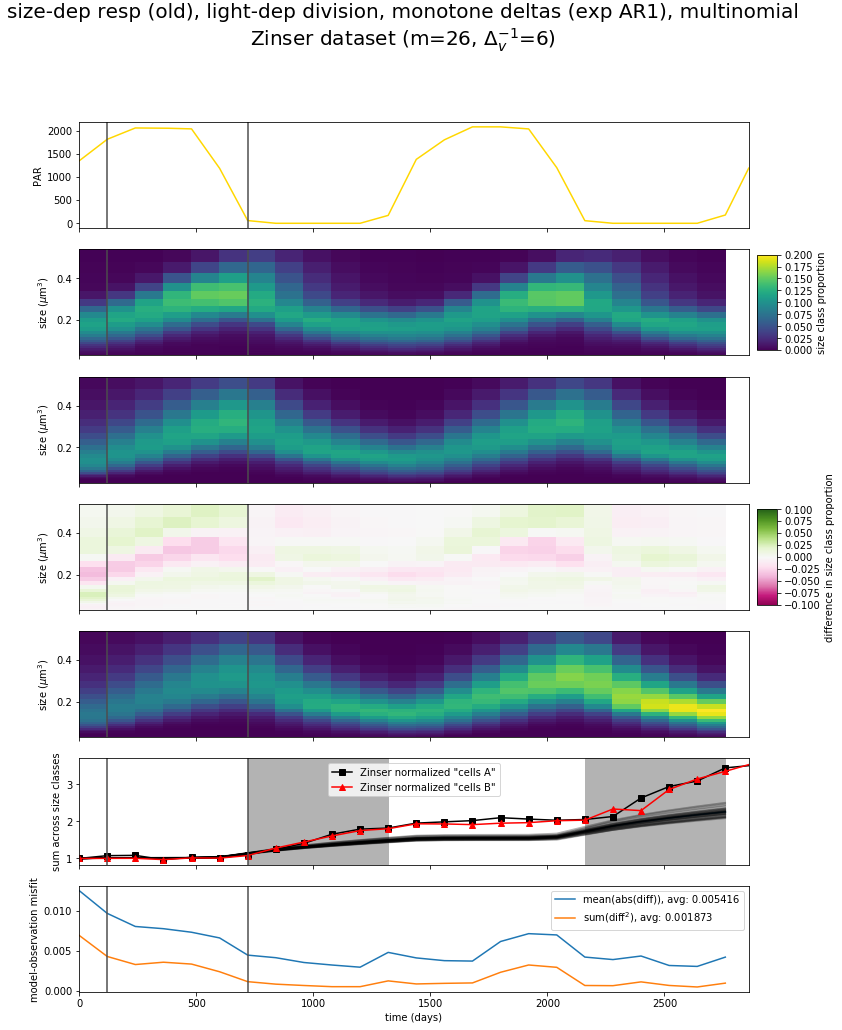

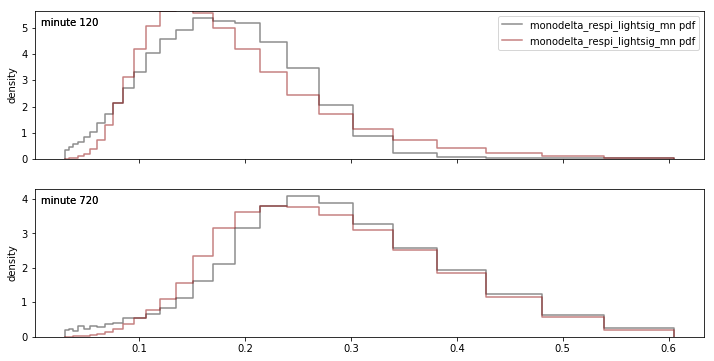

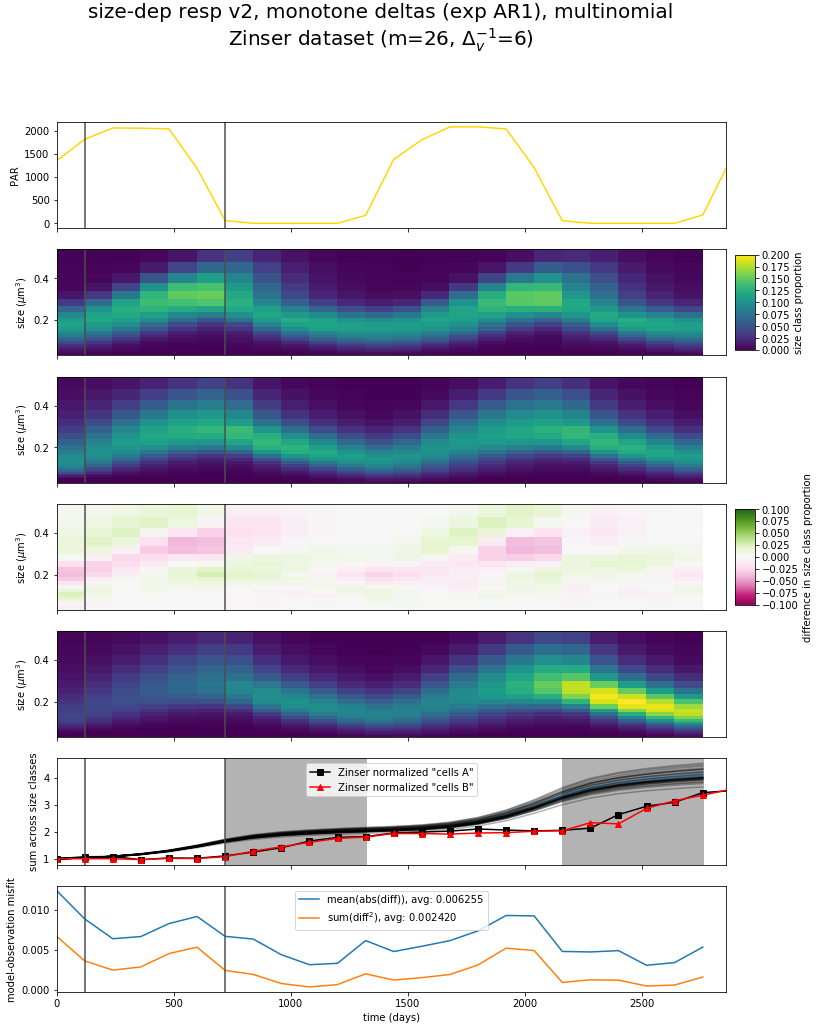

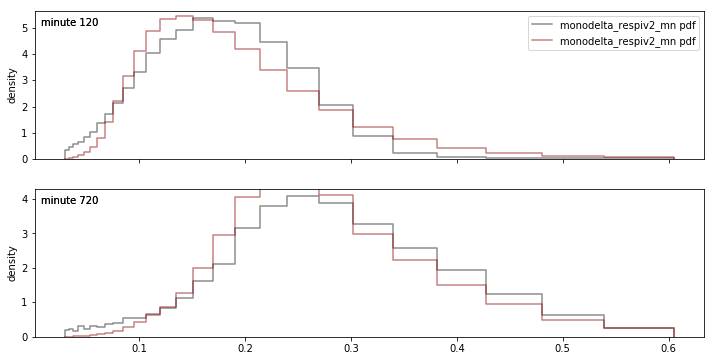

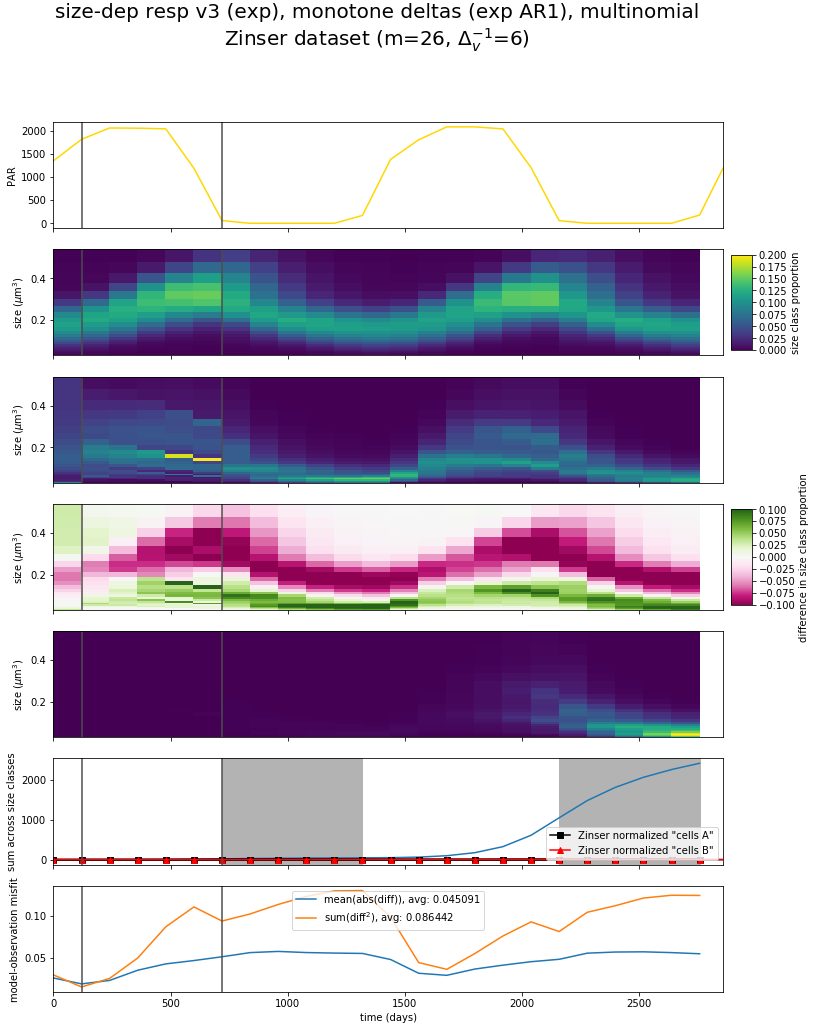

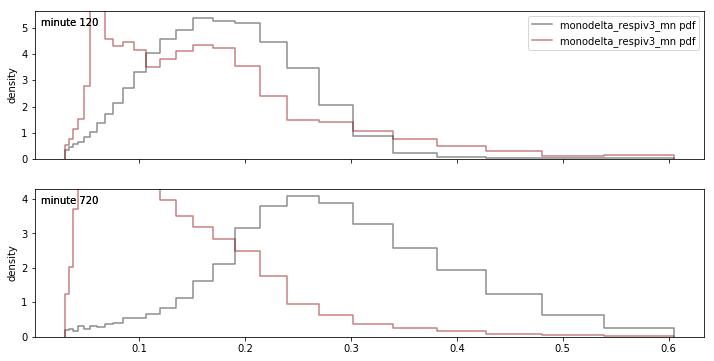

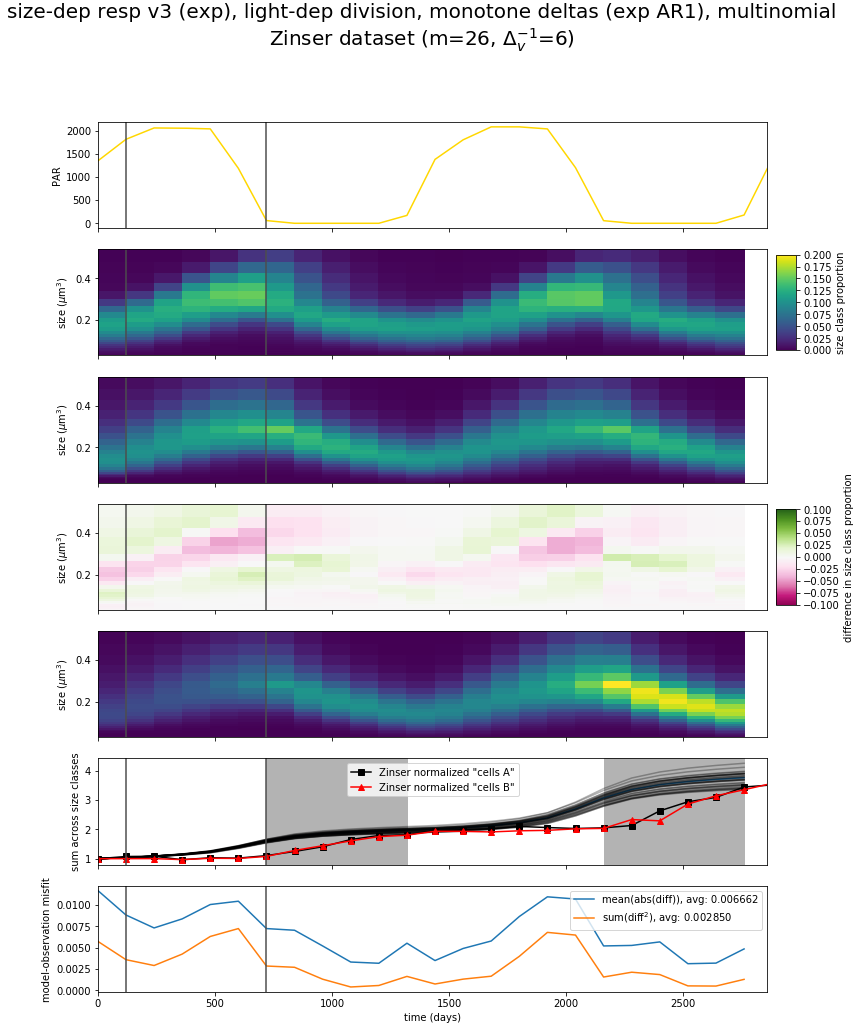

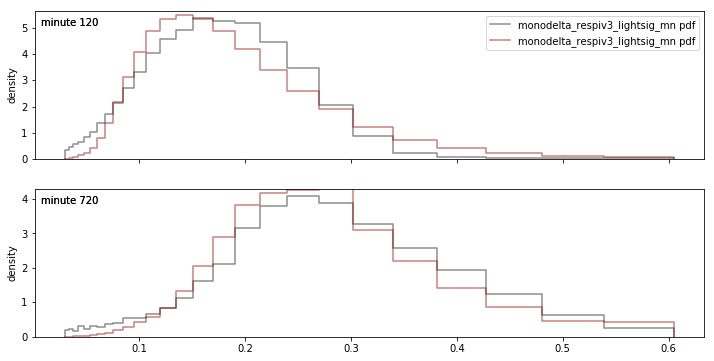

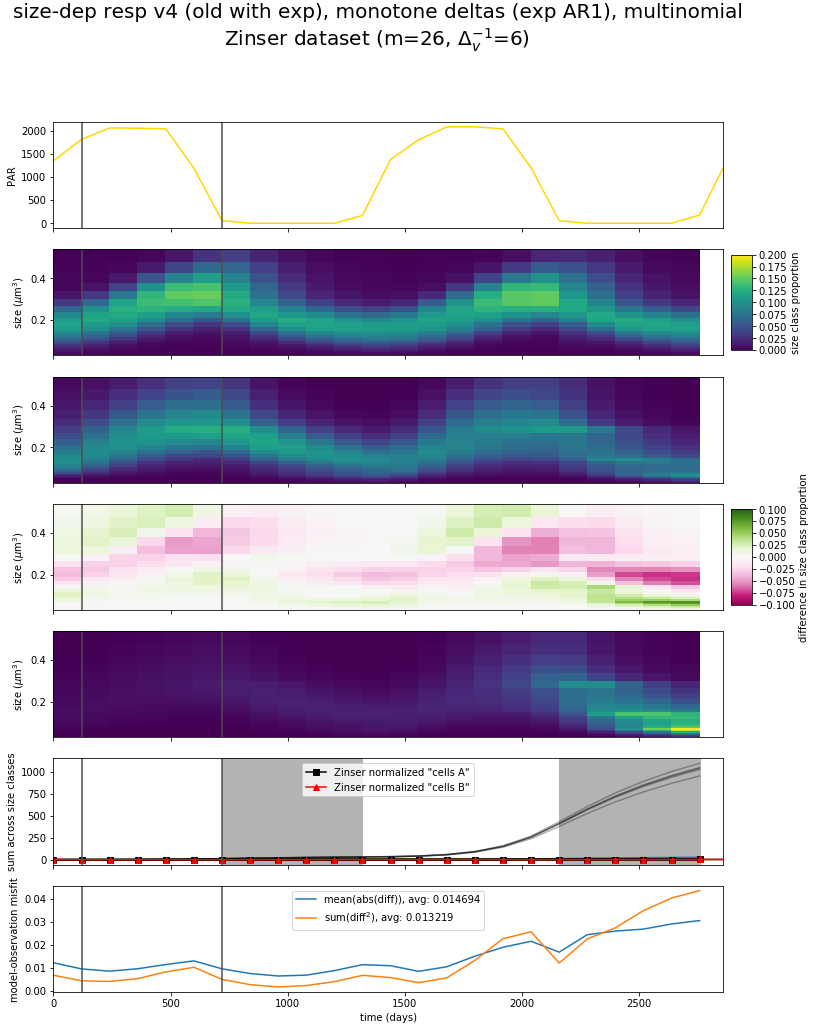

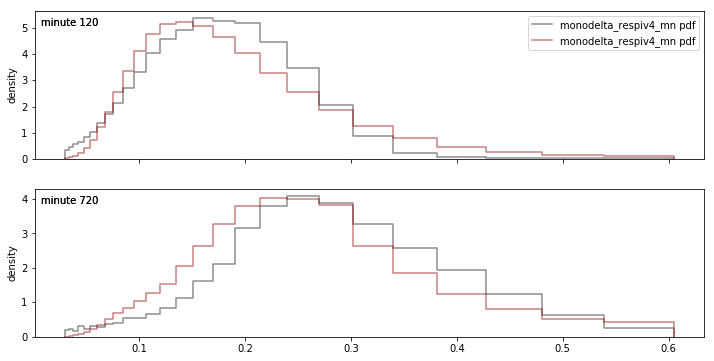

In [10]:
import pandas

data_fig2a = pandas.read_csv('data/Zinser_Figure2A.csv')

t_zinser = data_fig2a['exper time'] * 60
a_norm = data_fig2a['cells A'].copy()
a_norm /= a_norm[0]
b_norm = data_fig2a['cells B'].copy()
b_norm /= b_norm[0]

colors = {'model':'darkred', 'obs':'0.1'}

norm = mpl.colors.Normalize(0.0,0.2)
norm_diff = mpl.colors.Normalize(-0.1,0.1)

for k in data:
    for name,mcmc in mcmcs.items():
        t = data[k]['dt']*np.arange(data[k]['nt'])
        if 'zinser' in k:
            slice_indices = [1,6]
        else:
            slice_indices = [6,12]
        v_ext = data[k]['v_min'] * 2**(np.arange(data[k]['m']+1)*delta_v) 
        v = v_ext[:-1]
        v_width = v_ext[1:] - v_ext[:-1]
        
        res = {'model':np.mean(mcmc[k]['mod_obspos'], axis=0), 'obs':data[k]['obs']}
        res_sum1 = res['model']/np.sum(res['model'], axis=0)[None,:]
        diff = res_sum1-res['obs']

        fig,axs = plt.subplots(7,1,sharex=True,figsize=(12,16))
        fig.suptitle(desc_model[name] + '\n' + desc[k], size=20)

        ax = axs[0]
        ax.plot(t, data[k]['E'], color='gold')
        ax.set(xlim=(data[k]['t_obs'][0],t[-1]), ylabel='PAR')

        ax = axs[1]
        pc = ax.pcolormesh(data[k]['t_obs'],v,res['obs'],norm=norm)
        ax.set(ylabel='size ($\mu$m$^3$)')
        add_colorbar(ax, norm=pc.norm, cmap=pc.cmap, label='size class proportion')

        ax = axs[2]
        ax.set(ylabel='size ($\mu$m$^3$)')
        pc = ax.pcolormesh(data[k]['t_obs'],v,res_sum1,norm=norm)

        ax = axs[3]
        pc = ax.pcolormesh(data[k]['t_obs'],v,diff,norm=norm_diff, cmap='PiYG')
        ax.set(ylabel='size ($\mu$m$^3$)')
        add_colorbar(ax, norm=pc.norm, cmap=pc.cmap, label='difference in size class proportion')

        ax = axs[4]
        ax.set(ylabel='size ($\mu$m$^3$)')
        pc = ax.pcolormesh(data[k]['t_obs'],v,res['model'])

        ax = axs[5]
        ax.plot(data[k]['t_obs'], np.sum(res['model'],axis=0))
        ax.plot(data[k]['t_obs'], np.sum(mcmc[k]['mod_obspos'][:30,...], axis=1).T, color='k', alpha=0.3)
        if 'zinser' in k:
            ax.plot(t_zinser, a_norm, color='black', marker='s', label='Zinser normalized "cells A"')
            ax.plot(t_zinser, b_norm, color='red', marker='^', label='Zinser normalized "cells B"')
            for iday in range(2):
                ax.axvspan(iday*24*60+12*60, iday*24*60+22*60, color='0.7', zorder=0)
            ax.legend()
        ax.set(ylabel='sum across size classes')

        ax = axs[6]
        prop = np.mean(np.abs(diff),axis=0)
        ax.plot(data[k]['t_obs'], prop, label='mean(abs(diff)), avg: {:.6f}'.format(np.mean(prop)))
        prop = np.sum(diff**2,axis=0)
        ax.plot(data[k]['t_obs'], prop, label='sum(diff$^2$), avg: {:.6f}'.format(np.mean(prop)))
        ax.set(xlabel='time (days)', ylabel='model-observation misfit')
        ax.legend()

        for ax in axs.flat:
            for i in slice_indices:
                ax.axvline(data[k]['t_obs'][i], color='.3')

        # plot slices

        plotdata_y = np.zeros(2*(data[k]['m']+1))

        fig,axs = plt.subplots(nrows=len(slice_indices), sharex=True, figsize=(12,len(slice_indices)*3))
        for i,ax in zip(slice_indices,axs.flat):
            for key in ('obs','model'):
                color = colors[key]
                cdata = res[key][:,i]
                cdata /= sum(cdata)
                plotdata_y[1:-1] = np.repeat(cdata/v_width,2)
                ax.plot(np.repeat(v_ext,2), plotdata_y, color=color, alpha=0.5, label='{} pdf'.format(name))
                ax.text(0.01, 0.95, 'minute {}'.format(data[k]['t_obs'][i]), transform=ax.transAxes, va='top', ha='left')
                ax.set_ylabel('density')
                ax.set_ylim(bottom=0.0)
        axs[0].legend()
        None

In [11]:
'''
for k in data:
    for name,mcmc in mcmcs.items():
        paramnames = [v for v in mcmc[k].flatnames if not v.startswith('mod_obspos') 
                      and not v.startswith('delta_max') and not v.startswith('w_ini') and not v.startswith('theta')]
        if len(paramnames) > 12:
            print('removing some parameters from plot')
            paramnames = paramnames[:12]
        num_params = len(paramnames)

        fig,axs = plt.subplots(num_params-1,num_params-1,sharex='col',sharey='row',figsize=(12,12), squeeze=False)
        fig.suptitle(desc_model[name] + '\n' + desc[k], size=20)
        for ax in axs.flat:
            ax.set_visible(False)
        for irow in range(1,num_params):
            for icol in range(irow):
                ax = axs[irow-1,icol]
                ax.set_visible(True)
                xname = paramnames[icol]
                yname = paramnames[irow]
                ax.hist2d(mcmc[k][xname],mcmc[k][yname],bins=50,cmap=mpl.cm.gray_r)
                if icol == 0:
                    ax.set_ylabel(yname)
                if irow == num_params-1:
                    ax.set_xlabel(xname)
'''
None

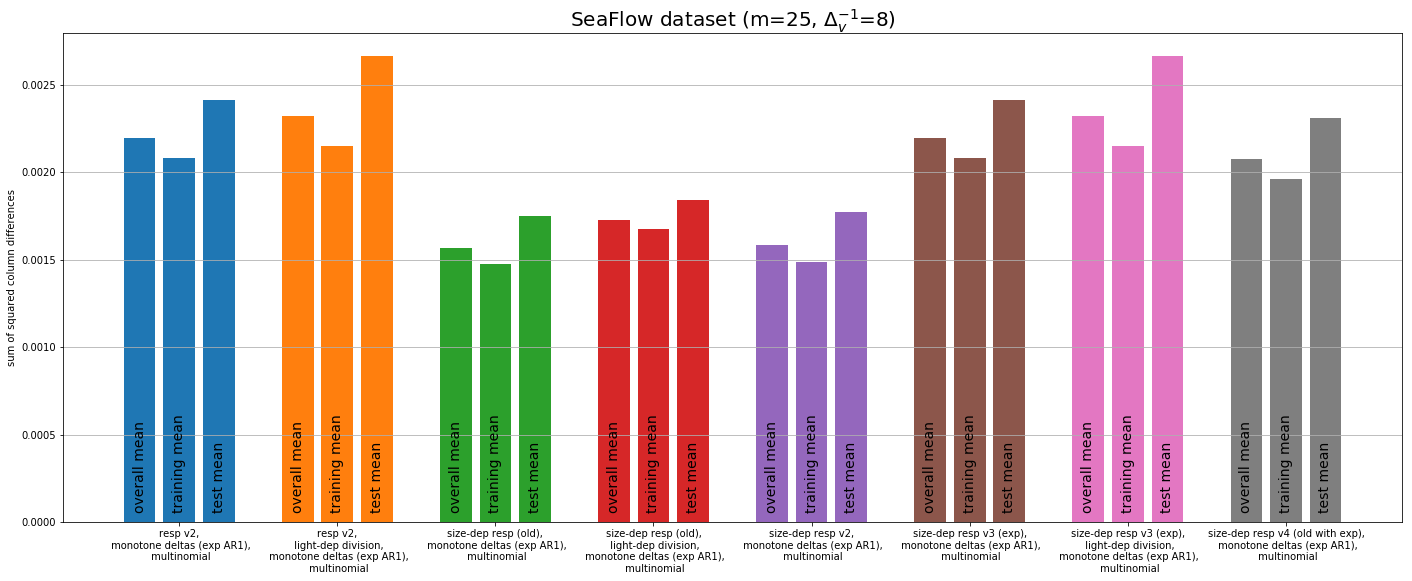

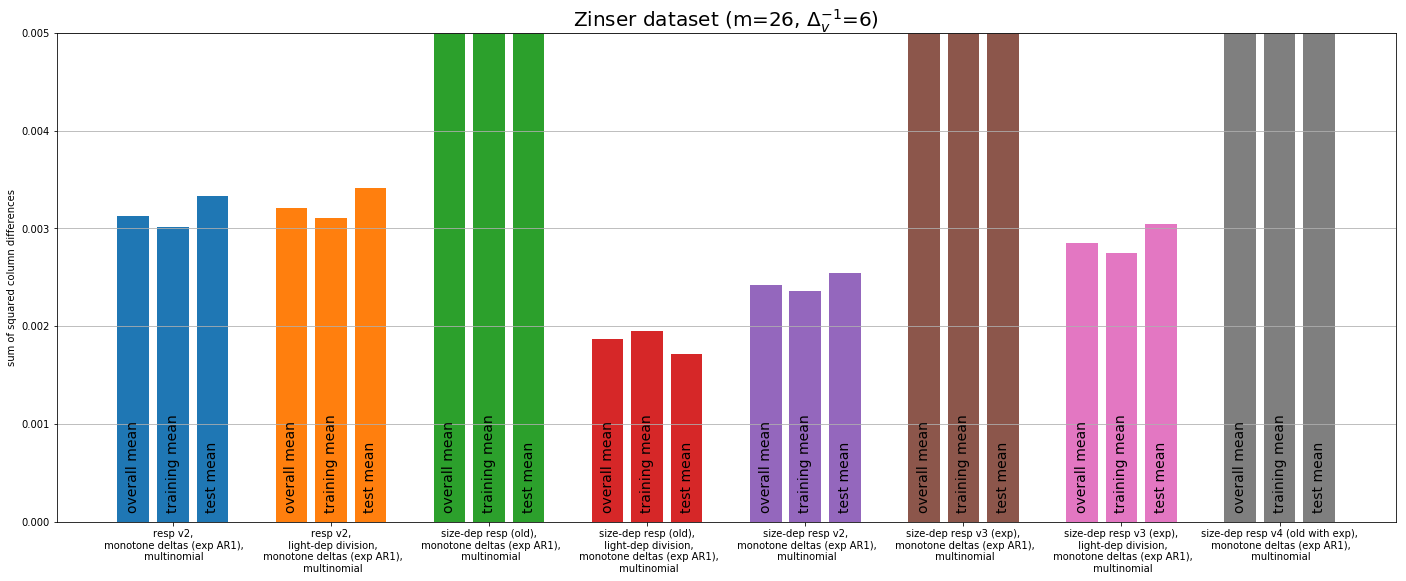

In [13]:
height = np.zeros(3)
for k in data:
    obs = data[k]['obs']
    
    fig, ax = plt.subplots(figsize=(24,9))
    xticks = []
    xticklabels = []
    for i,name in enumerate(mcmcs):
        mod_mean = np.mean(mcmcs[name][k]['mod_obspos'], axis=0)
        mod_mean /= np.sum(mod_mean, axis=0)
        
        e = np.sum((mod_mean-obs)**2,axis=0)
        #print(desc_model[name],e)
        
        height[0] = np.mean(e)
        height[1] = np.mean(e[data[k]['i_test'] == 0])
        height[2] = np.mean(e[data[k]['i_test'] == 1])
        
        x = 4*i+np.arange(3)
        ax.bar(x=x, height=height)
        for xx,text in zip(x,['overall mean','training mean','test mean']):
            ax.text(xx, 0, '  '+text, rotation=90, ha='center', va='bottom', size=14)
        xticks.append(x[1])
        xticklabels.append(desc_model[name].replace(',',',\n'))
    
    if ax.get_ylim()[1] > 0.005:
        ax.set_ylim(top=0.005)
    ax.set(ylabel='sum of squared column differences', xticks=xticks)
    ax.set_title(desc[k], size=20)
    ax.set_xticklabels(xticklabels)#, rotation=8)
    ax.grid(axis='y')